# Valid Pairings Categories

**Goal:** See how our observed upper limits *change* when we instead do a full 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import uproot
import pickle
import json
from tqdm import tqdm

import os
os.sys.path.append('../../hh4b-background-estimation/hep_ml')
from hep_ml import reweight

os.sys.path.append('../code')
from AnalysisUtils import nanoToDf
from plotting import sig_bkg_massplanes, bkg_2bsameHC_massplanes, bkg_2b_rw_massplanes
from plotting import cf_1d_dists, plot_results, invert_interval
from plotting import SR_x,SR_y1,SR_y2,CR_x,CR_y1,CR_y2,SB_x,SB_y1,SB_y2

import pyhf 
from pyhf import Model, optimizer

%load_ext autoreload
%autoreload 2

Running w/ conda env: don't import root packages.


## Step 1: Reproduce the baseline analysis with pyhf

Also, in my `Baseline-Analysis` notebook, I was reweighting *before* the $X_{wt}$ cut instead of *after*.

**Load in the data**

In [3]:
fileName = "../../hh4b-resolved-reconstruction/{}_topo_2016triggers.root"

smnr   = nanoToDf(fileName.format("smnr"),ttree='fullmassplane')
data16 = nanoToDf(fileName.format("data16"),ttree='fullmassplane')

fullmassplane
fullmassplane


**Reweight *after* $X_{wt}$**

In [4]:
trainBDT = False
makeBDTPlots = False

BDT_fname = "myBDTs/BDT_d24_16_rel21_baseline.p"
sort_rw_cols = ['pT_4', 'pT_2', 'eta_i', 'dRjj_1', 'dRjj_2', 'njets']

In [5]:
if trainBDT:

    BDT_params = {
        'n_estimators' : 50,
        'learning_rate' : 0.1,
        'max_depth' : 3,
        'min_samples_leaf' : 125,
        'gb_args' : {'subsample': 0.4}
    }


    reweighter = reweight.GBReweighter(n_estimators=BDT_params['n_estimators'], 
                                       learning_rate=BDT_params['learning_rate'], 
                                       max_depth=BDT_params['max_depth'],
                                       min_samples_leaf=BDT_params['min_samples_leaf'],
                                       gb_args=BDT_params['gb_args'])

    original = data16.loc[(data16.ntag == 2)&(data16.kinematic_region == 2),sort_rw_cols]
    target = data16.loc[(data16.ntag >= 4)&(data16.kinematic_region == 2),sort_rw_cols]
     
    print("Training on columns:", sort_rw_cols)
    reweighter.fit(original, target)

    pickle.dump(reweighter, open( BDT_fname, "wb" ))
    
else:

    reweighter = pickle.load(open( BDT_fname, "rb" ))


In [6]:
N4bTo2b = np.sum((data16.ntag>=4) & (data16.kinematic_region==2)) / np.sum((data16.ntag==2) & (data16.kinematic_region==2))

data16['w_2b'] = N4bTo2b * reweighter.predict_weights(data16[sort_rw_cols])

**Check the 2b and 4b agreement**

**SB**

In [7]:
dataText = "$\mathbf{ATLAS}$ Internal 2016 data\n"
dataText += "MDR + min $D_{hh}$"

In [8]:
if makeBDTPlots:
    cf_1d_dists(data16,mask=(data16.kinematic_region==2),drawUnweighted=False, 
                dataText=dataText,nbi=25,
                figDir='figures/baseline/rw_2b/',tag='_SB',chi2Only=False)

**CR**

In [9]:
if makeBDTPlots:
    cf_1d_dists(data16,mask=(data16.kinematic_region==1),drawUnweighted=False, 
            dataText=dataText,nbi=25,color_2b='C9',title='control region',
            figDir='figures/baseline/rw_2b/',tag='_CR',chi2Only=False)

**Get the expected upper limit on $\mu$**

In [10]:
# Define the pyhf model

def simple(signal_data,bkg_data,batch_size=None):
    spec = {
        'channels':[
            {
                'name': 'singlechannel',
                'samples' : [
                    {
                        'name': 'signal',
                        'data': signal_data,
                        'modifiers': [
                            {'name': 'mu', 'type': 'normfactor', 'data': None}
                        ],   
                    },
                    {
                        'name': 'background',
                        'data':bkg_data,
                        'modifiers':[  
                        ],
                    },  
                ],
            }
        ]
    }
    return pyhf.Model(spec, batch_size=batch_size)


In [11]:
bkg_SR = (data16.ntag==2)&(data16.kinematic_region==0)
sig_SR = (smnr.ntag>=4)&(smnr.kinematic_region==0)

In [12]:
edges = np.array([150, 250, 262, 275, 288, 302, 317, 332, 348, 365, 383, 402, 422, 443, 465, 488, 512, 
                  537, 563, 591, 620, 651, 683, 717, 752, 789, 828, 869, 912, 957,1004, 1054, 1106, 1161, 
                  1219, 1279, 1342, 1409, 1479, 1552, 1629, 1710, 1795, 1884, 1978, 2076])

sm_hh,_ = np.histogram(smnr.loc[sig_SR,'m_hh'], edges,
                       weights=smnr.loc[sig_SR,'mc_sf'])
qcd_hh,_ = np.histogram(data16.loc[bkg_SR,'m_hh'], edges, 
                        weights=data16.loc[bkg_SR,'w_2b'])

In [13]:
m = simple(list(sm_hh), list(qcd_hh))

In [14]:
mu_tests = np.linspace(1,40, 40)

hypo_tests = [pyhf.utils.hypotest(mu, m.expected_data([0]), m, 0.5, [(0,40)],
                                  return_expected_set=True, return_test_statistics=True,
                                  qtilde=True)
              for mu in mu_tests]

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: divide by zero encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in multiply
  return n * np.log(lam) - lam - gammaln(n + 1.0)


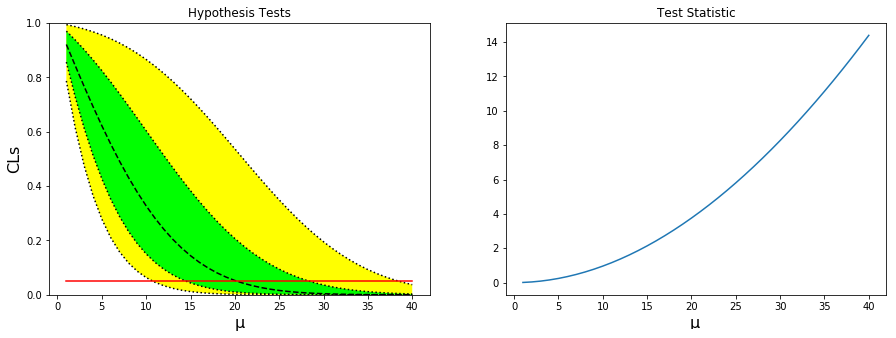

In [15]:
test_stats = np.array([test[-1][0] for test in hypo_tests]).flatten()
cls_obs = np.array([test[0] for test in hypo_tests]).flatten()
cls_exp = [np.array([test[1][i] for test in hypo_tests]).flatten() for i in range(5)]

fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

ax1.set_title(u'Hypothesis Tests')
ax1.set_ylabel(u'CLs',fontsize=16)
ax1.set_xlabel(u'µ',fontsize=16)
plot_results(ax1, mu_tests, cls_obs, cls_exp)

ax2.set_title(u'Test Statistic')
ax2.set_xlabel(u'µ',fontsize=16)

ax2.plot(mu_tests,test_stats)
plt.savefig('figures/baseline/scan_mu.pdf')
plt.show()

In [16]:
results_baseline = invert_interval(mu_tests, cls_obs, cls_exp)

mu_unsc = results_baseline['exp'][2]

print('Observed Limit: {:.3f}'.format(results_baseline['obs']))
print('-----')
for i, n_sigma in enumerate(np.arange(-2,3)):
    print('Expected Limit{}: {:.2f}'.format('' if n_sigma==0 else '({} σ)'.format(n_sigma),results_baseline['exp'][i]))

Observed Limit: 20.249
-----
Expected Limit(-2 σ): 10.77
Expected Limit(-1 σ): 14.51
Expected Limit: 20.25
Expected Limit(1 σ): 28.42
Expected Limit(2 σ): 38.51


In [17]:
mu_unsc

20.248934303324262

In [18]:
np.min(sm_hh)

0.0

**Comparison with the HistFactory result**

In [19]:
mu_HF = 20.2959

print("{:.3f}% difference w/ the exp mu from HistFactory".format((mu_HF-mu_unsc)/mu_HF*100))


0.231% difference w/ the exp mu from HistFactory


In [20]:
(20.30-20.28)/20.30*100

0.09852216748768262

This is a .1% percent difference, I think it seems tolerable.

**Conclusions:** Ok, so that was just validating the setup that I have right now, but there were a couple of other studies that I was interested in doing with the "up and running" stats code.

**Check the # of bins**

Michael was also telling me this was supposed to be super exciting so that we can tell *where* in the $m_{hh}$ spectrum the power of our analysis is coming from.

*How do I think I might be able to test this???*

- I think for the baseline analysis, I might be able to look at the signal and background histograms, *but* I should do it as a ratio plot with $s/\sqrt{b}$ below, so that I can understand how our bins might contribute more or less to our sensitivity!


/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


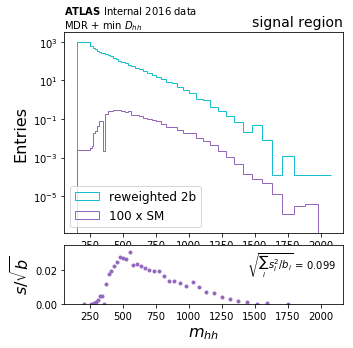

In [21]:
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(4,1)
ax1 = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax1)

b,_,_ = ax1.hist(data16.loc[bkg_SR,'m_hh'],
                 edges,color='C9',histtype='step',log=True,
                 label='reweighted 2b',
                 weights=data16.loc[bkg_SR,'w_2b'])

s,_,_ = ax1.hist(smnr.loc[sig_SR,'m_hh'],
                 edges,color='C4',histtype='step',log=True,
                 label='100 x SM',
                 weights=smnr.loc[sig_SR,'mc_sf'])

ax2.plot(0.5*(edges[:-1]+edges[1:]),s/np.sqrt(b),marker='.',color='C4',linewidth=0)
ax2.set_xlabel('$m_{hh}$',fontsize=16)
ax2.set_ylim(0,.035)

_,ymax = ax1.get_ylim()
ax1.set_ylim(0,ymax)

ax1.set_ylabel('Entries',fontsize=16)
ax1.text(0,1,dataText,ha='left',va='bottom',transform=ax1.transAxes)

sigText = '$\sqrt{\sum_i{s_i^2 / b_i}}$ = '
sigText += '{:.3f}'.format(np.sqrt(np.sum(s[b!=0]**2 / b[b!=0])))

ax2.text(.975,.9,sigText,ha='right',va='top',transform=ax2.transAxes)
ax2.set_ylabel('$s / \sqrt{b}$',fontsize=16)

ax1.legend(fontsize=12,loc="lower left")

ax1.set_title('signal region', loc='right',fontsize=14)

plt.savefig('figures/baseline/m_hh_SR_log_ratio.pdf')
plt.show()

Ok, so based on this plot, it seems like to me that this is 2x as many bins as we need?

What else could we look at?
1. Just use half as many bins
2. Use the bins suggested by the benchmark cluster analysis paper: 50 equally spaced bins from 0 - 1500 GeV.
3. Use the bins from the Wisconsin group:
4. Use Sean's bins: 

Ok, so I think I can do the upper limits on $\mu$ like Michael said, but I can also compare this with the $\sqrt{\sum_i s_i^2 / b_i }$, and see if the trend persists.

A nice summary plot might be the different binnings and the significances with $\mu$.

And since the Wisconsin group is using 40 bins of width 25 GeV from 200 to 1200 GeV, I'll probably expect this to be an intermediate region b/w what Sean and the cluster benchmark papers were doing.

In [22]:
(1200-200)/40

25.0

In [23]:
np.linspace(200,1200,41)

array([ 200.,  225.,  250.,  275.,  300.,  325.,  350.,  375.,  400.,
        425.,  450.,  475.,  500.,  525.,  550.,  575.,  600.,  625.,
        650.,  675.,  700.,  725.,  750.,  775.,  800.,  825.,  850.,
        875.,  900.,  925.,  950.,  975., 1000., 1025., 1050., 1075.,
       1100., 1125., 1150., 1175., 1200.])

In [24]:
def getExpectedBand(s,b,mus,alpha=0.05):
    '''
    Given histograms for signal and a background and a grid of mu values to test,
    return a list for the -2 sigma, -1 sigma, exp mu, +1 sigma, +2 sigma limits. 
    '''
    
    # Define the pyhf model
    mi = simple(list(s), list(b))
    
    # Get the scan over mu
    hypo_tests = [pyhf.utils.hypotest(mu, mi.expected_data([0]), mi, 
                                      0.5, [(0,np.max(mus))],
                                      return_expected_set=True, 
                                      return_test_statistics=True,
                                      qtilde=True)
                  for mu in mus]
   
    cls_exp = [np.array([test[1][i] for test in hypo_tests]).flatten() for i in range(5)]

    # Invert the interval
    band = [np.interp(alpha, list(reversed(y_vals)), list(reversed(mus)))
            for y_vals in cls_exp]
    
    return band
    

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


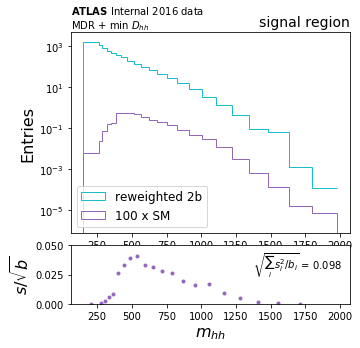

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


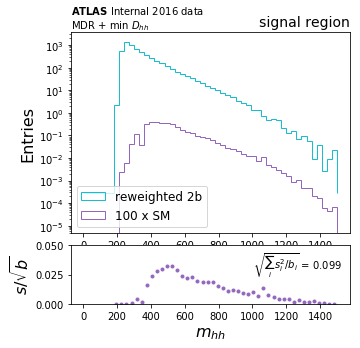

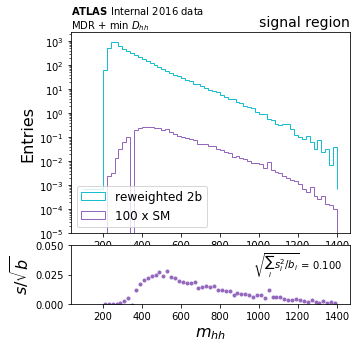

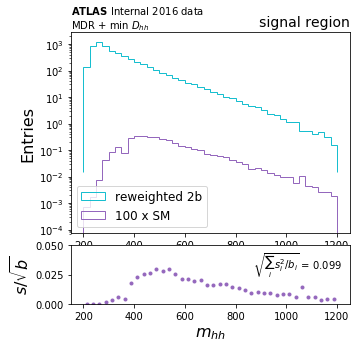

In [25]:
tags = ['2x_paper','pangea','Sean','Rui']
bin_bands = {'baseline': results_baseline['exp']}

for edg, tag in zip([edges[::2], np.linspace(0,1500,51), np.linspace(100,1400,66), np.linspace(200,1200,41)],
                    tags):
    
    '''
    Make the mhh in the SR plot
    '''
    fig = plt.figure(figsize=(5, 5))
    gs = gridspec.GridSpec(4,1)
    ax1 = fig.add_subplot(gs[:3,0])
    ax2 = fig.add_subplot(gs[3:,0],sharex=ax1)

    b,_,_ = ax1.hist(data16.loc[bkg_SR,'m_hh'],
                     edg,color='C9',histtype='step',log=True,
                     label='reweighted 2b',
                     weights=data16.loc[bkg_SR,'w_2b'])

    s,_,_ = ax1.hist(smnr.loc[sig_SR,'m_hh'],
                     edg,color='C4',histtype='step',log=True,
                     label='100 x SM',
                     weights=smnr.loc[sig_SR,'mc_sf'])

    ax2.plot(0.5*(edg[:-1]+edg[1:]),s/np.sqrt(b),marker='.',color='C4',linewidth=0)
    ax2.set_xlabel('$m_{hh}$',fontsize=16)
    ax2.set_ylim(0,.05)

    _,ymax = ax1.get_ylim()
    ax1.set_ylim(0,ymax)

    ax1.set_ylabel('Entries',fontsize=16)
    ax1.text(0,1,dataText,ha='left',va='bottom',transform=ax1.transAxes)
    
    sigText = '$\sqrt{\sum_i{s_i^2 / b_i}}$ = '
    sigText += '{:.3f}'.format(np.sqrt(np.sum(s[b!=0]**2 / b[b!=0])))

    ax2.text(.975,.9,sigText,ha='right',va='top',transform=ax2.transAxes)
    ax2.set_ylabel('$s / \sqrt{b}$',fontsize=16)

    ax1.legend(fontsize=12,loc="lower left")

    ax1.set_title('signal region', loc='right',fontsize=14)

    plt.savefig('figures/baseline/m_hh_SR_log_ratio_{}.pdf'.format(tag))
    plt.show()
    
    # Get the bands
    bin_bands[tag] = getExpectedBand(s,b,mu_tests)
        

It *might* also be nice to have a way to aggregate all of this information into a single plot as well!

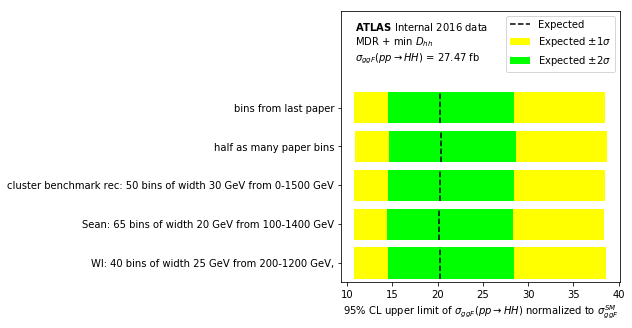

In [26]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

plot_tags = ['baseline'] + tags

labels = [
    'bins from last paper',
    'half as many paper bins',
    'cluster benchmark rec: 50 bins of width 30 GeV from 0-1500 GeV',
    'Sean: 65 bins of width 20 GeV from 100-1400 GeV',
    'WI: 40 bins of width 25 GeV from 200-1200 GeV,'
]

eps = .1

for ymin, tag in zip(np.arange(5)[::-1],plot_tags):
    
    cls_exp = bin_bands[tag]
    
    plt.fill_between([cls_exp[0],cls_exp[-1]], [ymin+eps]*2,[ymin+1-eps]*2, 
                    facecolor = 'yellow', label='Expected $\pm 1\sigma$' if tag=='baseline' else None)
    plt.fill_between([cls_exp[1],cls_exp[-2]], [ymin+eps]*2,[ymin+1-eps]*2, 
                    facecolor = 'lime', label='Expected $\pm 2\sigma$' if tag=='baseline' else None)
    
    plt.plot([cls_exp[2]]*2,[ymin+eps,ymin+1-eps],'k--',label='Expected' if tag=='baseline' else None)
    
ax.set_yticks(np.arange(5)+0.5)
ax.set_yticklabels(labels[::-1])   
 
'''
Put some text on the top of the figure corresponding 
to the signal that we're looking at.
'''
plt.ylim(0,7)
plt.text(0.05,0.95,dataText+'\n'+r'$\sigma_{ggF}(pp \rightarrow HH)$ = 27.47 fb',
         ha='left',va='top',transform=ax.transAxes)
plt.legend(loc='upper right')
    
plt.xlabel(r'95% CL upper limit of $\sigma_{ggF}(pp \rightarrow HH)$ normalized to $\sigma_{ggF}^{SM}$')

plt.savefig('figures/baseline/exp_mu_varyingBins.pdf'.format(tag),bbox_inches='tight')

plt.show()

Ok, I think this is a good lesson. For a stats only limit, I don't think having overly coarse bins is hurting us at all.

But I guess the good news is a version of this plot is what Michael wants me to try to optimize?

**Do a 2d fit with $\Delta \eta_{hh}$ as well**

In [27]:
data16.columns

Index(['run_number', 'event_number', 'mc_sf', 'ntag', 'njets', 'nValidPairs',
       'kinematic_region', 'm_hh', 'pt_hh', 'X_wt', 'm_hh_cor', 'm_h1', 'E_h1',
       'pT_h1', 'eta_h1', 'phi_h1', 'dRjj_h1', 'm_h2', 'E_h2', 'pT_h2',
       'eta_h2', 'phi_h2', 'dRjj_h2', 'm_h1_j1', 'E_h1_j1', 'pT_h1_j1',
       'eta_h1_j1', 'phi_h1_j1', 'tag_h1_j1', 'angle_h1_j1', 'm_h1_j2',
       'E_h1_j2', 'pT_h1_j2', 'eta_h1_j2', 'phi_h1_j2', 'tag_h1_j2',
       'angle_h1_j2', 'm_h2_j1', 'E_h2_j1', 'pT_h2_j1', 'eta_h2_j1',
       'phi_h2_j1', 'tag_h2_j1', 'angle_h2_j1', 'm_h2_j2', 'E_h2_j2',
       'pT_h2_j2', 'eta_h2_j2', 'phi_h2_j2', 'tag_h2_j2', 'angle_h2_j2',
       'pT_4', 'pT_2', 'eta_i', 'dRjj_1', 'dRjj_2', 'w_2b'],
      dtype='object')

In [28]:
data16['deta_hh'] = np.abs(data16['eta_h1']-data16['eta_h2'])
smnr['deta_hh'] = np.abs(smnr['eta_h1']-smnr['eta_h2'])

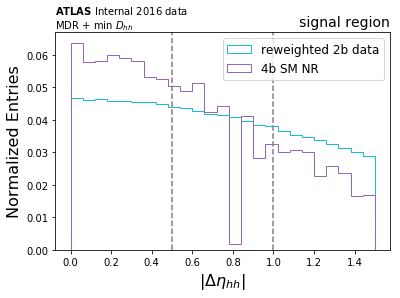

In [29]:
plt.hist(data16.loc[bkg_SR,'deta_hh'],25,(0,1.5),
         label='reweighted 2b data',color='C9',histtype='step',
         weights=data16.loc[bkg_SR,'w_2b']/np.sum(data16.loc[bkg_SR,'w_2b']))

plt.hist(smnr.loc[sig_SR,'deta_hh'],25,(0,1.5),
         label='4b SM NR',color='C4',histtype='step',
         weights=smnr.loc[sig_SR,'mc_sf']/np.sum(smnr.loc[sig_SR,'mc_sf']))

plt.legend(fontsize=12)
plt.xlabel('$|\Delta \eta_{hh}|$',fontsize=16)
plt.ylabel('Normalized Entries',fontsize=16)

ax1 = plt.gca()
plt.text(0,1,dataText,ha='left',va='bottom',transform=ax1.transAxes)
plt.title('signal region', loc='right',fontsize=14)

# Add some proposals for deta categories
ylim = plt.ylim()
for etai in [0.5,1]:
    plt.plot(2*[etai],ylim,'grey',linestyle='--')
plt.ylim(ylim)

plt.savefig('figures/baseline/deta_hh_SR.pdf')
plt.show()

Next: lets make a flattened histogram!

In [30]:
eta_edges = np.array([0, 0.5, 1.0, 1.5])

sm_hh_eta,_,_  = np.histogram2d(smnr.loc[sig_SR,'m_hh'], smnr.loc[sig_SR,'deta_hh'], 
                                [edges, eta_edges], weights=smnr.loc[sig_SR,'mc_sf'])
qcd_hh_eta,_,_ = np.histogram2d(data16.loc[bkg_SR,'m_hh'], data16.loc[bkg_SR,'deta_hh'], 
                                [edges, eta_edges], weights=data16.loc[bkg_SR,'w_2b'])

In [31]:
np.min(sm_hh_eta)

-0.08843161283155622

Ok, so Matthew told me that it mathematically *really doesn't make sense* to have bins with a negative rate because you don't know how to interpret a *negative* Poisson rate, so Max just suggested not letting the signal histogram have entries below 0. 

In [32]:
def hist2dToList(hist,minZero=True):
    
    ylist = []

    for yi in hist:
        ylist += list(np.where(yi>0,yi,0) if minZero else yi)

    return ylist

In [33]:
m_etaBins = simple(hist2dToList(sm_hh_eta), hist2dToList(qcd_hh_eta))

Take a look at what the flatten histogram looks like!

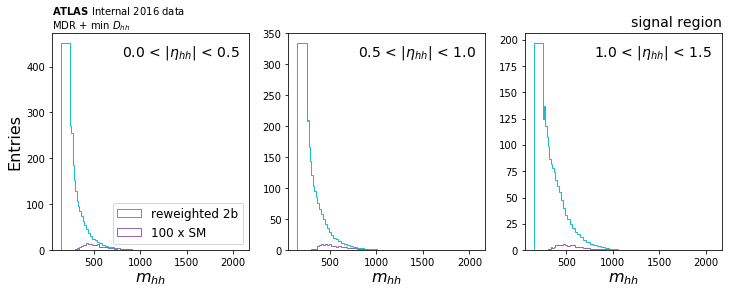

In [34]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches(12, 4)

for ax, min_eta,max_eta in zip(axes,eta_edges[:-1],eta_edges[1:]):

    
    ax.hist(data16.loc[bkg_SR & (data16.deta_hh > min_eta) & (data16.deta_hh < max_eta),'m_hh'],
             edges,color='C9',histtype='step',
             label='reweighted 2b',
             weights=data16.loc[bkg_SR & (data16.deta_hh > min_eta) & (data16.deta_hh < max_eta),'w_2b'])

    ax.hist(smnr.loc[sig_SR & (smnr.deta_hh > min_eta) & (smnr.deta_hh < max_eta),'m_hh'],
             edges,color='C4',histtype='step',
             label='100 x SM',
             weights=100*smnr.loc[sig_SR & (smnr.deta_hh > min_eta) & (smnr.deta_hh < max_eta),'mc_sf'])

    ax.set_xlabel('$m_{hh}$',fontsize=16)
    
    _,ymax = ax.get_ylim()
    ax.set_ylim(0,ymax)
    
    ax.text(.95,.95,str(min_eta)+' < |$\eta_{hh}$| < '+str(max_eta),
             ha='right',va='top',transform=ax.transAxes,fontsize=14)
    
    
axes[0].set_ylabel('Entries',fontsize=16)
axes[0].text(0,1,dataText,ha='left',va='bottom',transform=axes[0].transAxes)
axes[0].legend(fontsize=12,loc='lower right')

plt.title('signal region', loc='right',fontsize=14)

plt.savefig('figures/baseline/m_hh_flattened_deta_hh_SR.pdf')
plt.show()

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


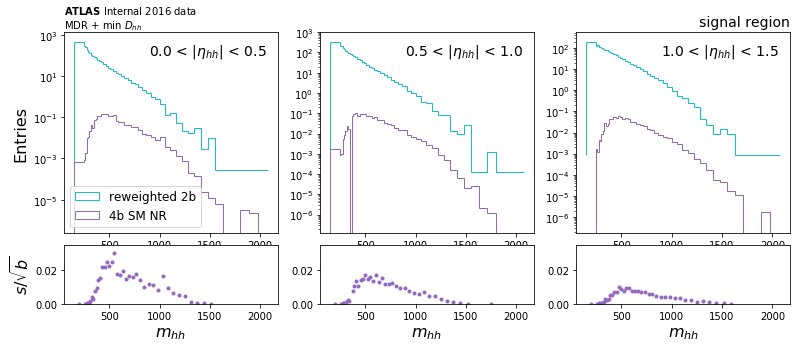

In [35]:
fig = plt.figure(figsize=(13, 5))
gs = gridspec.GridSpec(4,3)

for i, min_eta,max_eta in zip(range(3),eta_edges[:-1],eta_edges[1:]):

    ax1 = fig.add_subplot(gs[:3,i])
    ax2 = fig.add_subplot(gs[3:,i],sharex=ax1)
    
    b,_,_ = ax1.hist(data16.loc[bkg_SR & (data16.deta_hh > min_eta) & (data16.deta_hh < max_eta),'m_hh'],
                     edges,color='C9',histtype='step',log=True,
                     label='reweighted 2b',
                     weights=data16.loc[bkg_SR & (data16.deta_hh > min_eta) & (data16.deta_hh < max_eta),'w_2b'])

    s,_,_ = ax1.hist(smnr.loc[sig_SR & (smnr.deta_hh > min_eta) & (smnr.deta_hh < max_eta),'m_hh'],
                     edges,color='C4',histtype='step',log=True,
                     label='4b SM NR',
                     weights=smnr.loc[sig_SR & (smnr.deta_hh > min_eta) & (smnr.deta_hh < max_eta),'mc_sf'])

    ax2.plot(0.5*(edges[:-1]+edges[1:]),s/np.sqrt(b),marker='.',color='C4',linewidth=0)
    ax2.set_xlabel('$m_{hh}$',fontsize=16)
    ax2.set_ylim(0,.035)
    
    _,ymax = ax1.get_ylim()
    ax1.set_ylim(0,ymax)
    
    ax1.text(.95,.95,str(min_eta)+' < |$\eta_{hh}$| < '+str(max_eta),
             ha='right',va='top',transform=ax1.transAxes,fontsize=14)
    
    if i == 0:
        ax1.set_ylabel('Entries',fontsize=16)
        ax1.text(0,1,dataText,ha='left',va='bottom',transform=ax1.transAxes)
        ax2.set_ylabel('$s / \sqrt{b}$',fontsize=16)

        ax1.legend(fontsize=12,loc="lower left")
    
ax1.set_title('signal region', loc='right',fontsize=14)

plt.savefig('figures/baseline/m_hh_flattened_deta_hh_SR_log_ratio.pdf')
plt.show()

In [36]:
hypo_tests_eta = [pyhf.utils.hypotest(mu, m_etaBins.expected_data([0]), m_etaBins, 0.5, [(0,40)],
                                      return_expected_set=True, 
                                      return_test_statistics=True,
                                      qtilde=True)
                  for mu in mu_tests]

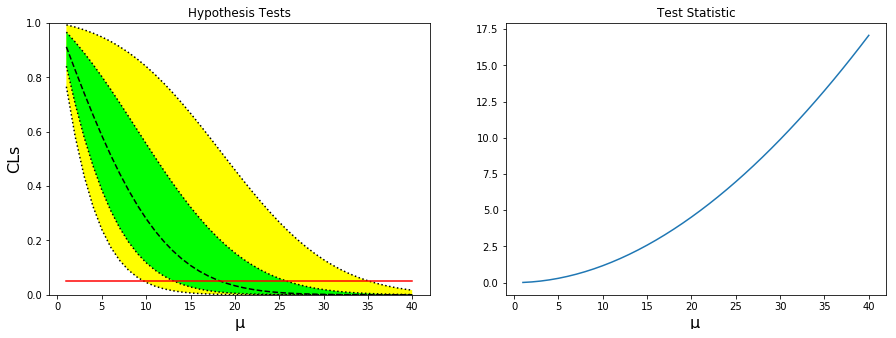

In [37]:
test_stats_eta = np.array([test[-1][0] for test in hypo_tests_eta]).flatten()
cls_obs_eta = np.array([test[0] for test in hypo_tests_eta]).flatten()
cls_exp_eta = [np.array([test[1][i] for test in hypo_tests_eta]).flatten() for i in range(5)]

fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

ax1.set_title(u'Hypothesis Tests')
ax1.set_ylabel(u'CLs',fontsize=16)
ax1.set_xlabel(u'µ',fontsize=16)
plot_results(ax1, mu_tests, cls_obs_eta, cls_exp_eta)

ax2.set_title(u'Test Statistic')
ax2.set_xlabel(u'µ',fontsize=16)

ax2.plot(mu_tests,test_stats_eta)
plt.savefig('figures/baseline/scan_mu_etaBins.pdf')
plt.show()

In [40]:
results_eta = invert_interval(mu_tests, cls_obs_eta, cls_exp_eta)

mu_eta = results_eta['exp'][2]

print('Observed Limit: {:.3f}'.format(results_eta['obs']))
print('-----')
for i, n_sigma in enumerate(np.arange(-2,3)):
    print('Expected Limit{}: {:.2f}'.format('' if n_sigma==0 else '({} σ)'.format(n_sigma),results_eta['exp'][i]))

Observed Limit: 18.407
-----
Expected Limit(-2 σ): 9.76
Expected Limit(-1 σ): 13.15
Expected Limit: 18.41
Expected Limit(1 σ): 25.88
Expected Limit(2 σ): 35.17


How does this translate into an improvement for our limits?

In [41]:
print("{:.3f}% difference w/ the exp mu from baseline".format((mu_unsc-mu_eta)/mu_unsc*100))

9.097% difference w/ the exp mu from baseline


Ok, so we found *another* 9% improvement just by doing a multi-dimensional fit... this is seems super encouraging!!!

The only thing is that these 9% improvements are well within the $1\sigma$ bands, so they might not be robust once we start including systematic uncertainties. But I guesss that's good to keep in mind anyways?


Curiosity question: What would this have looked like just in terms of a significance gain?

In [42]:
s0 = np.sqrt(np.sum(np.power(sm_hh[qcd_hh > 0] / np.sqrt(qcd_hh[qcd_hh > 0]),2)))

In [43]:
s1 = np.sqrt(np.sum(np.power(sm_hh_eta[qcd_hh_eta > 0] / np.sqrt(qcd_hh_eta[qcd_hh_eta > 0]),2)))

In [44]:
print('baseline significance: {:.3f}'.format(s0))
print('deta(hh) significance: {:.3f}'.format(s1))
print('Percent gain: {:.1f}%'.format((s1-s0)/s0*100))

baseline significance: 0.099
deta(hh) significance: 0.110
Percent gain: 11.3%


So, not a huge gain, but not laughable either. It's also interesting that it seems like the significance is roughly scaling like the upper limit on $\mu$... good to know! (I guess I'll have to follow-up later to see why this is.)

**Comparison with $CL_{s+b}$**

Ok, so the pure frequentist limit would just set a limit on $\mu$ where $CL_{s+b}$ was 5%... so I wanted to see how much we lost in terms of our analysis sensitivity through this more conservative limit.

In [45]:
hypo_tests2 = [pyhf.utils.hypotest(mu, m.expected_data([0]), m, 1, [(0,40)],
                                  return_tail_probs=True,
                                  return_expected_set=True, 
                                  return_test_statistics=True,
                                  qtilde=True)
              for mu in mu_tests]

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: divide by zero encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in multiply
  return n * np.log(lam) - lam - gammaln(n + 1.0)


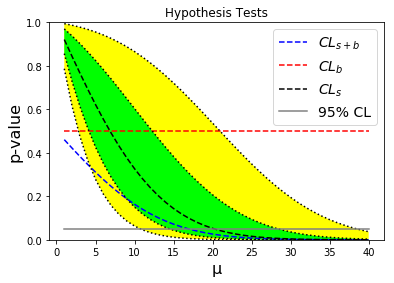

In [46]:
test_stats = np.array([test[-1][0] for test in hypo_tests2]).flatten()
cls_obs = np.array([test[0] for test in hypo_tests2]).flatten()

cls_b = np.array([test[1][0] for test in hypo_tests2]).flatten()
clb = np.array([test[1][1] for test in hypo_tests2]).flatten()

cls_exp = [np.array([test[2][i] for test in hypo_tests2]).flatten() for i in range(5)]

plt.title(u'Hypothesis Tests')
plt.ylabel(u'p-value',fontsize=16)
plt.xlabel(u'µ',fontsize=16)

ax = plt.gca()

ax.plot(mu_tests, cls_b, c='b',linestyle='dashed',label='$CL_{s+b}$') 
ax.plot(mu_tests, clb, c='r',linestyle='dashed',label='$CL_b$') 

for i,c in zip(range(5),['k','k','k','k','k']):
    ax.plot(mu_tests, cls_exp[i], c = c, 
            linestyle = 'dotted' if i!=2 else 'dashed',
            label = None if i!=2 else '$CL_{s}$')
ax.fill_between(mu_tests,cls_exp[0],cls_exp[-1], facecolor = 'yellow')
ax.fill_between(mu_tests,cls_exp[1],cls_exp[-2], facecolor = 'lime')
ax.plot(mu_tests,[0.05]*len(mu_tests), c = 'grey',label='95% CL')
ax.set_ylim(0,1)

plt.legend(fontsize=14)

plt.savefig('figures/baseline/cf_scan_mu_CLs+b.pdf')
plt.show()

What would have been the upper limit that we would have set on $\mu$ with the $CL_{s+b}$ line?

In [47]:
mu_freq = np.interp(0.05, list(reversed(cls_b)), list(reversed(mu_tests)))
mu_freq

16.92211012253265

In [48]:
(20.2-16.85)/20.2

0.16584158415841574

**Q:** Why is the background flat and at 0.5 at this point?

The background is flat because the best fit value for $\hat{\mu} = 0$, which means the test statistic $\tilde{q}_\mu = 0$, and doesn't depend on $\mu$.

The background being 0.5 is just a consistency check that the a histogram's compatibility w/ itself is as likely to be expressed by an upward or downward fluctuation of the signal strenth (maybe?).


## Step 2: Check the background model in the valid pairings categories 

We want to see if reweighting in each of these categories *separately* can improve our background modelling. (I'm a little doubtful, because it didn't look like reweighted with the 2b same HC helped, because this reweighting procedure might be statistically limited.)


Let's just train each of these individual BDTs w/ the same hyperparameters that were used in the full one.

In [49]:
trainBDT

False

In [50]:
for nv in [1,2,3]:
    
    BDT_fname = "myBDTs/BDT_d24_16_rel21_{}validPair.p"
    
    if trainBDT:

        BDT_params = {
            'n_estimators' : 50,
            'learning_rate' : 0.1,
            'max_depth' : 3,
            'min_samples_leaf' : 125,
            'gb_args' : {'subsample': 0.4}
        }


        reweighter_nv = reweight.GBReweighter(n_estimators=BDT_params['n_estimators'], 
                                           learning_rate=BDT_params['learning_rate'], 
                                           max_depth=BDT_params['max_depth'],
                                           min_samples_leaf=BDT_params['min_samples_leaf'],
                                           gb_args=BDT_params['gb_args'])

        original = data16.loc[(data16.ntag == 2)&\
                              (data16.kinematic_region == 2)&\
                              (data16.nValidPairs==nv),
                              sort_rw_cols]
        target = data16.loc[(data16.ntag >= 4)&\
                            (data16.kinematic_region == 2)&\
                            (data16.nValidPairs==nv),
                            sort_rw_cols]

        print("Training on columns:", sort_rw_cols)
        reweighter_nv.fit(original, target)

        pickle.dump(reweighter, open( BDT_fname, "wb" ))

    else:

        reweighter_nv = pickle.load(open( BDT_fname, "rb" ))

    '''
    Save the weights
    '''
    N4bTo2b_nv = np.sum((data16.ntag>=4) & (data16.kinematic_region==2) & (data16.nValidPairs==nv)) / np.sum((data16.ntag==2) & (data16.kinematic_region==2) & (data16.nValidPairs==nv))
    data16['w_2b_nv{}'.format(nv)] = N4bTo2b_nv * reweighter_nv.predict_weights(data16[sort_rw_cols])
    
    print(N4bTo2b_nv)
    
    del reweighter_nv
    

0.005921359875414216
0.006215388444493608
0.0066565809379727685


**Hypothesis:** It's not the weights that have changed, just the normalizations, but good that the weights that we derived in the full background model also hold in these separate subspaces.

**SB**

In [52]:
if makeBDTPlots:
    for nv,c in zip([1,2,3],['C6','C4','C2']):
    
        mask = (data16.kinematic_region==2) & (data16.nValidPairs==nv)
        extra_w = 'w_2b_nv{}'.format(nv)
        extra_label = '2b rw {} valid pair{}'.format(nv,"s" if nv != 1 else "")

        cf_1d_dists(data16,mask=mask,drawUnweighted=False,extra_w=extra_w,
                    dataText=dataText+": {} valid pairing".format(nv),
                    nbi=25,color_2bsameHC=c,extra_label=extra_label,
                    figDir='figures/baseline/rw_2b/',tag='_SB_nv{}'.format(nv),chi2Only=False)

Ok, so what I'm taking from here is that our reweighting over all the pairings is doing just as well as the reweighting for the single pairings, but I think it is probably worthwhile to do some things like double check the weights, and whether the reweighting that was derived with just one valid pairing gives the same answer as the one derived for 3 valid pairings?

In [53]:
data16[['nValidPairs','w_2b','w_2b_nv1','w_2b_nv2','w_2b_nv3']].head()

nValidPairs      w_2b  w_2b_nv1  w_2b_nv2  w_2b_nv3
entry                                                     
0                1  0.004024  0.003952  0.004149  0.004443
1                1  0.012805  0.012578  0.013203  0.014140
2                2  0.003550  0.003487  0.003660  0.003920
3                2  0.002767  0.002718  0.002853  0.003055
4                1  0.005524  0.005426  0.005696  0.006100

Ok, so I think this is good news, they're definitely doing something different, but w_2b most closely matches whichever w_2b_nv the # of valid pairings corresponds to.

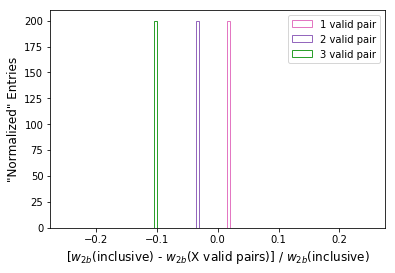

In [54]:
for nv,c in zip([1,2,3],['C6','C4','C2']):
    
    mask2b = (data16.ntag==2) & (data16.nValidPairs==nv)
    plt.hist((data16.loc[mask2b,'w_2b']-data16.loc[mask2b,'w_2b_nv{}'.format(nv)])/data16.loc[mask2b,'w_2b'],
             100,(-.25,.25),
             color=c,histtype='step',
             label='{} valid pair'.format(nv),density=True)
    
plt.legend()
plt.xlabel('[$w_{2b}$(inclusive) - $w_{2b}$(X valid pairs)] / $w_{2b}$(inclusive)',fontsize=12)
plt.ylabel('"Normalized" Entries',fontsize=12)
plt.show()

Ok, so what this means is that the only thing that seems to be different between these values is some kind of normalization, does this make sense?

I think so. I think this just means that our background estimation derived in the full phase space does a good job reproducing the kinematics in the individual phase spaces.

**CR**

In [56]:
if makeBDTPlots:
    for nv,c in zip([1,2,3],['C6','C4','C2']):
    
        mask = (data16.kinematic_region==1) & (data16.nValidPairs==nv)
        extra_w = 'w_2b_nv{}'.format(nv)
        extra_label = '2b rw {} valid pair{}'.format(nv,"s" if nv != 1 else "")

        cf_1d_dists(data16,mask=(data16.kinematic_region==1),drawUnweighted=False, 
                    extra_w=extra_w,color_2bsameHC=c,extra_label=extra_label,
                    dataText=dataText+": {} valid pairing".format(nv),
                    nbi=25,color_2b='C9',title='control region',
                    figDir='figures/baseline/rw_2b/',tag='_CR_nv{}'.format(nv),chi2Only=False)

Ok, so I don't think my stats are high enough to make this reweighting in the individual categories as advantageous... but maybe I also have a bug??

## Step 3: Limit with this new categorization

Recall: In my baseline analysis notebook, this only changed the significance by 1%, but by doing this study here, we'll get a more firm answer.

Anyways, I *think* I should just use the full background reweighting, since I think playing w/ hyperparameters might be outside of the scope of this task.

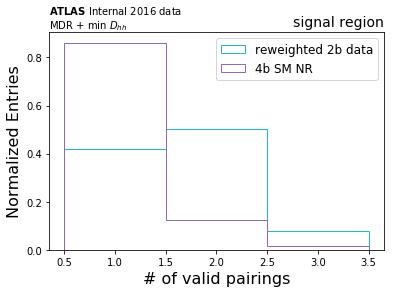

In [57]:
nv_edges = np.array([0.5, 1.5, 2.5, 3.5])

plt.hist(data16.loc[bkg_SR,'nValidPairs'],nv_edges,
         label='reweighted 2b data',color='C9',histtype='step',
         weights=data16.loc[bkg_SR,'w_2b']/np.sum(data16.loc[bkg_SR,'w_2b']))

plt.hist(smnr.loc[sig_SR,'nValidPairs'],nv_edges,
         label='4b SM NR',color='C4',histtype='step',
         weights=smnr.loc[sig_SR,'mc_sf']/np.sum(smnr.loc[sig_SR,'mc_sf']))

plt.legend(fontsize=12)
plt.xlabel('# of valid pairings',fontsize=16)
plt.ylabel('Normalized Entries',fontsize=16)

ax1 = plt.gca()
plt.text(0,1,dataText,ha='left',va='bottom',transform=ax1.transAxes)
plt.title('signal region', loc='right',fontsize=14)

plt.savefig('figures/baseline/normalized_nValidPairs.pdf')
plt.show()

In [58]:
sm_hh_nv,_,_  = np.histogram2d(smnr.loc[sig_SR,'m_hh'], smnr.loc[sig_SR,'nValidPairs'], 
                                [edges, nv_edges], weights=smnr.loc[sig_SR,'mc_sf'])
qcd_hh_nv,_,_ = np.histogram2d(data16.loc[bkg_SR,'m_hh'], data16.loc[bkg_SR,'nValidPairs'], 
                                [edges, nv_edges], weights=data16.loc[bkg_SR,'w_2b'])

In [59]:
 m_nv = simple(hist2dToList(sm_hh_nv), hist2dToList(qcd_hh_nv))

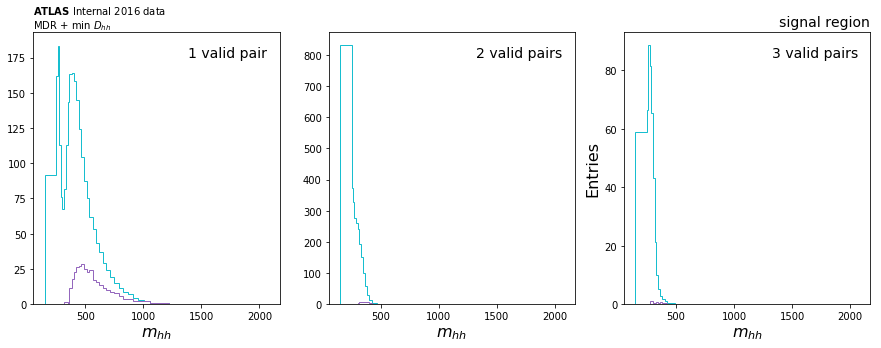

In [60]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches(15, 5)

for ax,nv in zip(axes,[1,2,3]):

    
    ax.hist(data16.loc[bkg_SR & (data16.nValidPairs==nv),'m_hh'],
             edges,color='C9',histtype='step',
             #label='reweighted 2b data',
             weights=data16.loc[bkg_SR & (data16.nValidPairs==nv),'w_2b'])

    ax.hist(smnr.loc[sig_SR & (smnr.nValidPairs == nv),'m_hh'],
             edges,color='C4',histtype='step',
             #label='4b SM NR',
             weights=100*smnr.loc[sig_SR & (smnr.nValidPairs == nv),'mc_sf'])

    ax.set_xlabel('$m_{hh}$',fontsize=16)
    
    _,ymax = ax.get_ylim()
    ax.set_ylim(0,ymax)
    
    ax.text(0.95,0.95,'{} valid pair{}'.format(nv,'s' if nv != 1 else ''),
            ha='right',va='top',transform=ax.transAxes,fontsize=14)
    
    
plt.ylabel('Entries',fontsize=16)

axes[0].text(0,1,dataText,ha='left',va='bottom',transform=axes[0].transAxes)
plt.title('signal region', loc='right',fontsize=14)

plt.savefig('figures/baseline/m_hh_flattened_nv_SR.pdf')
plt.show()

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


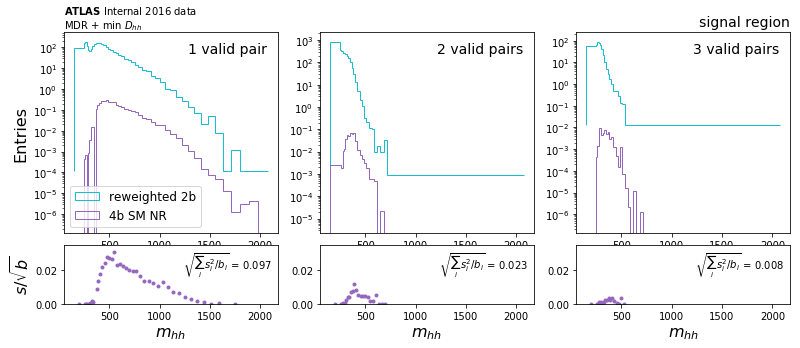

In [61]:
fig = plt.figure(figsize=(13, 5))
gs = gridspec.GridSpec(4,3)

for i,nv in enumerate([1,2,3]):

    ax1 = fig.add_subplot(gs[:3,i])
    ax2 = fig.add_subplot(gs[3:,i],sharex=ax1)
    
    b,_,_ = ax1.hist(data16.loc[bkg_SR & (data16.nValidPairs==nv),'m_hh'],
                     edges,color='C9',histtype='step',log=True,
                     label='reweighted 2b',
                     weights=data16.loc[bkg_SR & (data16.nValidPairs==nv),'w_2b'])

    s,_,_ = ax1.hist(smnr.loc[sig_SR & (smnr.nValidPairs == nv),'m_hh'],
                     edges,color='C4',histtype='step',log=True,
                     label='4b SM NR',
                     weights=smnr.loc[sig_SR & (smnr.nValidPairs == nv),'mc_sf'])

    ax2.plot(0.5*(edges[:-1]+edges[1:]),s/np.sqrt(b),marker='.',color='C4',linewidth=0)
    ax2.set_xlabel('$m_{hh}$',fontsize=16)
    ax2.set_ylim(0,.035)
    
    _,ymax = ax1.get_ylim()
    ax1.set_ylim(0,ymax)
    
    ax1.text(0.95,0.95,'{} valid pair{}'.format(nv,'s' if nv != 1 else ''),
             ha='right',va='top',transform=ax1.transAxes,fontsize=14)
    
    sigText = '$\sqrt{\sum_i{s_i^2 / b_i}}$ = '
    sigText += '{:.3f}'.format(np.sqrt(np.sum(s[b!=0]**2 / b[b!=0])))

    ax2.text(.975,.9,sigText,ha='right',va='top',transform=ax2.transAxes)
    
    if i == 0:
        ax1.set_ylabel('Entries',fontsize=16)
        ax1.text(0,1,dataText,ha='left',va='bottom',transform=ax1.transAxes)
        ax2.set_ylabel('$s / \sqrt{b}$',fontsize=16)

        ax1.legend(fontsize=12,loc="lower left")
    
ax1.set_title('signal region', loc='right',fontsize=14)

plt.savefig('figures/baseline/m_hh_flattened_nv_SR_log_ratio.pdf')
plt.show()

In [62]:
hypo_tests_nv = [pyhf.utils.hypotest(mu, m_nv.expected_data([0]), m_nv, 0.5, [(0,40)],
                                      return_expected_set=True, 
                                      return_test_statistics=True,
                                      qtilde=True)
                  for mu in mu_tests]

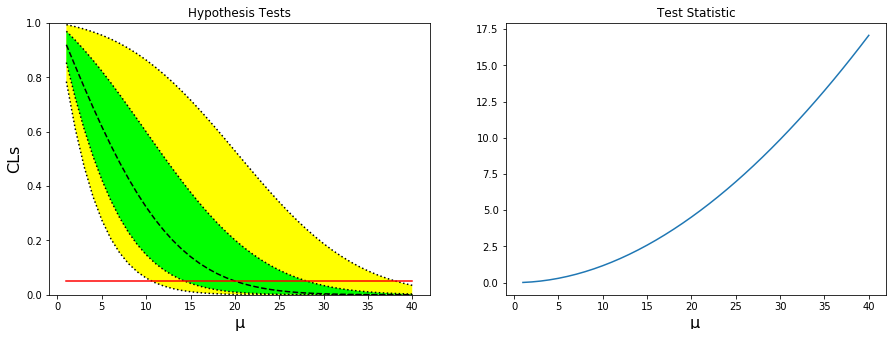

In [63]:
test_stats_nv = np.array([test[-1][0] for test in hypo_tests_nv]).flatten()
cls_obs_nv = np.array([test[0] for test in hypo_tests_nv]).flatten()
cls_exp_nv = [np.array([test[1][i] for test in hypo_tests_nv]).flatten() for i in range(5)]

fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

ax1.set_title(u'Hypothesis Tests')
ax1.set_ylabel(u'CLs',fontsize=16)
ax1.set_xlabel(u'µ',fontsize=16)
plot_results(ax1, mu_tests, cls_obs_nv, cls_exp_nv)

ax2.set_title(u'Test Statistic')
ax2.set_xlabel(u'µ',fontsize=16)

ax2.plot(mu_tests,test_stats_eta)
plt.savefig('figures/baseline/scan_mu_nv.pdf')
plt.show()

In [66]:
results_nv = invert_interval(mu_tests, cls_obs_nv, cls_exp_nv)

mu_nv = results_nv['exp'][2]

print('Observed Limit: {:.3f}'.format(results_nv['obs']))
print('-----')
for i, n_sigma in enumerate(np.arange(-2,3)):
    print('Expected Limit{}: {:.2f}'.format('' if n_sigma==0 else '({} σ)'.format(n_sigma),results_nv['exp'][i]))

Observed Limit: 20.060
-----
Expected Limit(-2 σ): 10.68
Expected Limit(-1 σ): 14.38
Expected Limit: 20.06
Expected Limit(1 σ): 28.17
Expected Limit(2 σ): 38.17


In [67]:
print("{:.3f}% difference w/ the exp mu from baseline".format((mu_unsc-mu_nv)/mu_unsc*100))

0.935% difference w/ the exp mu from baseline


Ok, so this is a (almost) 1% improvement.

**Conclusions:** I don't think for the upper limit on $\mu$ it's worthwhile exploring this any further, but it could still be worthwhile for the other limit we set for the NR analysis: the $\kappa_\lambda$ scan.

# $\kappa_\lambda$ variations

Ok, so I *think* I have some good first order results, but I think the next order-of-business is to see how these results depend on $\kappa_\lambda$. Max sent me a root file that says how we should change our signal weights by to get these different $\kappa_\lambda$ values, and Jana *thought* that these weights were derived for the $m_{hh}$ values, but I guess I can see what kind of difference this might make?

The only other thing is that we have these different cross-sections, so I'll need to (somehow) correct for this as well? (I guess I can ask Max what scaling I need to apply though).

**Step 1:** Make plots of the weight matrices that are stored in this root file.


In [68]:
lambdaFile = "../data/LambdaWeightFile.root"
f = uproot.open(lambdaFile)

for k in f.keys():
    print(k)

b'weight_lambda-20;1'
b'weight_lambda-19;1'
b'weight_lambda-18;1'
b'weight_lambda-17;1'
b'weight_lambda-16;1'
b'weight_lambda-15;1'
b'weight_lambda-14;1'
b'weight_lambda-13;1'
b'weight_lambda-12;1'
b'weight_lambda-11;1'
b'weight_lambda-10;1'
b'weight_lambda-09;1'
b'weight_lambda-08;1'
b'weight_lambda-07;1'
b'weight_lambda-06;1'
b'weight_lambda-05;1'
b'weight_lambda-04;1'
b'weight_lambda-03;1'
b'weight_lambda-02;1'
b'weight_lambda-01;1'
b'weight_lambda00;1'
b'weight_lambda01;1'
b'weight_lambda02;1'
b'weight_lambda03;1'
b'weight_lambda04;1'
b'weight_lambda05;1'
b'weight_lambda06;1'
b'weight_lambda07;1'
b'weight_lambda08;1'
b'weight_lambda09;1'
b'weight_lambda10;1'
b'weight_lambda11;1'
b'weight_lambda12;1'
b'weight_lambda13;1'
b'weight_lambda14;1'
b'weight_lambda15;1'
b'weight_lambda16;1'
b'weight_lambda17;1'
b'weight_lambda18;1'
b'weight_lambda19;1'
b'weight_lambda20;1'


In [69]:
for ttree in f.keys():
    
    tree = uproot.open(lambdaFile)[ttree]
    
    l = ttree.decode()[13:][:-2]
    
    '''
    Check for underflow and overflow
    '''
    underflow = tree.allvalues[0]
    overflow  = tree.allvalues[-1]
    print('lambda {}: underflow = {}, overflow = {}'.format(l,underflow,overflow))
    

lambda -20: underflow = 0.0, overflow = 0.0
lambda -19: underflow = 0.0, overflow = 0.0
lambda -18: underflow = 0.0, overflow = 0.0
lambda -17: underflow = 0.0, overflow = 0.0
lambda -16: underflow = 0.0, overflow = 0.0
lambda -15: underflow = 0.0, overflow = 0.0
lambda -14: underflow = 0.0, overflow = 0.0
lambda -13: underflow = 0.0, overflow = 0.0
lambda -12: underflow = 0.0, overflow = 0.0
lambda -11: underflow = 0.0, overflow = 0.0
lambda -10: underflow = 0.0, overflow = 0.0
lambda -09: underflow = 0.0, overflow = 0.0
lambda -08: underflow = 0.0, overflow = 0.0
lambda -07: underflow = 0.0, overflow = 0.0
lambda -06: underflow = 0.0, overflow = 0.0
lambda -05: underflow = 0.0, overflow = 0.0
lambda -04: underflow = 0.0, overflow = 0.0
lambda -03: underflow = 0.0, overflow = 0.0
lambda -02: underflow = 0.0, overflow = 0.0
lambda -01: underflow = 0.0, overflow = 0.0
lambda 00: underflow = 0.0, overflow = 0.0
lambda 01: underflow = 0.0, overflow = 0.0
lambda 02: underflow = 0.0, overfl

In [70]:
tree.values

array([ 7.2558027e+03,  1.8357209e+03,  6.7915308e+02,  3.2492441e+02,
        1.6771582e+02,  9.5130600e+01,  6.6770538e+01,  5.2438324e+01,
        4.4545204e+01,  3.4910034e+01,  3.0072144e+01,  2.6179596e+01,
        2.2967121e+01,  2.0209442e+01,  1.6893314e+01,  1.7956930e+01,
        1.3541462e+01,  1.3098597e+01,  9.8841295e+00,  1.2325759e+01,
        9.0636978e+00,  1.0223915e+01,  6.8370895e+00,  9.4115229e+00,
        8.4612188e+00,  8.8265648e+00,  9.4456415e+00,  8.4362659e+00,
        8.7468958e+00,  7.0714583e+00,  6.2782269e+00,  7.3167819e-01,
        7.7806354e+00,  2.9899284e-01,  3.8866036e+00,  7.3132081e+00,
        1.6864351e+00,  1.8842376e+00,  5.0418367e+00, -6.6731501e-01,
       -5.1747119e-01,  1.0520351e+01, -1.4003551e+00,  1.9084805e-01,
        1.6122555e+00,  3.0821168e+00, -4.0416846e+00,  1.1554184e+01,
       -9.2825022e+00,  1.0730313e+01, -1.3520620e-02, -3.1531618e+00,
        2.3582012e+01, -1.4673160e+00,  1.0050705e+01, -9.8354826e+00,
      

In [71]:
len(tree.values)

90

In [72]:
edges

array([ 150,  250,  262,  275,  288,  302,  317,  332,  348,  365,  383,
        402,  422,  443,  465,  488,  512,  537,  563,  591,  620,  651,
        683,  717,  752,  789,  828,  869,  912,  957, 1004, 1054, 1106,
       1161, 1219, 1279, 1342, 1409, 1479, 1552, 1629, 1710, 1795, 1884,
       1978, 2076])

In [73]:
tree.edges

array([ 250.,  270.,  290.,  310.,  330.,  350.,  370.,  390.,  410.,
        430.,  450.,  470.,  490.,  510.,  530.,  550.,  570.,  590.,
        610.,  630.,  650.,  670.,  690.,  710.,  730.,  750.,  770.,
        790.,  810.,  830.,  850.,  870.,  890.,  910.,  930.,  950.,
        970.,  990., 1010., 1030., 1050., 1070., 1090., 1110., 1130.,
       1150., 1170., 1190., 1210., 1230., 1250., 1270., 1290., 1310.,
       1330., 1350., 1370., 1390., 1410., 1430., 1450., 1470., 1490.,
       1510., 1530., 1550., 1570., 1590., 1610., 1630., 1650., 1670.,
       1690., 1710., 1730., 1750., 1770., 1790., 1810., 1830., 1850.,
       1870., 1890., 1910., 1930., 1950., 1970., 1990., 2010., 2030.,
       2050.])

In [74]:
len(tree.edges)

91

Ok, so *this* is good to know, we have different edges for the reweighted histogram versus the "nominal" ones that Jana sent me.

Fyi, rn Sean is using 66 bins from 100 to 1400.

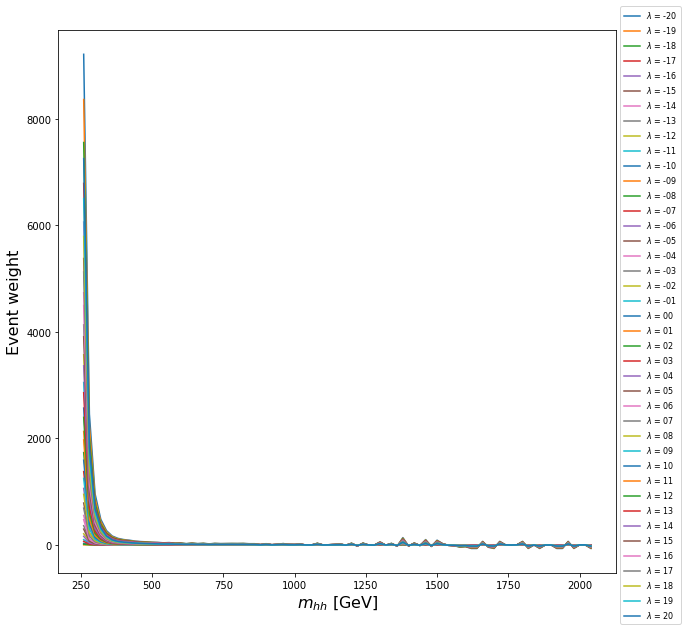

In [75]:
plt.figure(figsize=(10,10))

for ttree in f.keys():
    
    tree = uproot.open(lambdaFile)[ttree]
    
    x = 0.5*(tree.edges[:-1] + tree.edges[1:])
    y = tree.values
    
    l = ttree.decode()[13:][:-2]
    plt.plot(x,y,label='$\lambda$ = {}'.format(l))
    
plt.xlabel('$m_{hh}$ [GeV]',fontsize=16)
plt.ylabel('Event weight',fontsize=16)
plt.legend(bbox_to_anchor=(1,1.05),fontsize=8)
plt.show()

Ok, so Max suggested looking at just a few representative values, i.e, 6 and 10, but I think it might also be useful to investigate some of the other $\kappa_\lambda$ values that were used in the combination.

<img src="figures/ATL-CONF-2018-043-Fig3.png" width=800 >

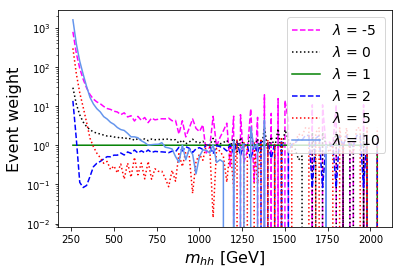

In [76]:
for lmbda, c, ls in zip([-5,0,1,2,5,10],['magenta','k','g','b','r','cornflowerblue'],['--',':','-']*2):
    
    if lmbda < 0:
        ttree = 'weight_lambda{:03};1'.format(lmbda)
    else:
        ttree = 'weight_lambda{:02};1'.format(lmbda)
         
    tree = uproot.open(lambdaFile)[ttree]
    
    x = 0.5*(tree.edges[:-1] + tree.edges[1:])
    y = tree.values
    
    plt.semilogy(x,y,color=c,linestyle=ls,label='$\lambda$ = {}'.format(lmbda))
        
plt.xlabel('$m_{hh}$ [GeV]',fontsize=16)
plt.ylabel('Event weight',fontsize=16)
plt.legend(fontsize=14)


plt.savefig('figures/baseline/weights_lambda.pdf')

plt.show()
    

Ok, so this roughly makes sense, and seems like what we might expect for the limits.
- The $\kappa_\lambda = 10$ sample is upweighting the low $m_{hh}$ values the most.
- $\kappa_\lambda = 2$ is showing the characteristic dip just above $m_{hh} = 300$ GeV corresponding to the (close to) maximal negative interference between the box and triangle diagrams.

**Step 2:** Look at the $m_{hh}$ plots for the $\kappa_\lambda$ variations that we have.

Since the edges start from 250 GeV, I *think* this means these weights were derived with the corrected $m_{hh}$ values. It does look like there will be some overflow for this sample though.

In [77]:
np.min(smnr['m_hh_cor']),np.max(smnr['m_hh_cor'])

(250.86677593816276, 2393.3526132887105)

In [78]:
for ttree in f.keys():
    
    tree = uproot.open(lambdaFile)[ttree]
    
    idx = np.digitize(smnr['m_hh_cor'],tree.edges) 
    
    l = ttree.decode()[13:][:-2]
    smnr['w_lambda{}'.format(int(l))] = tree.allvalues[idx] * smnr['mc_sf']

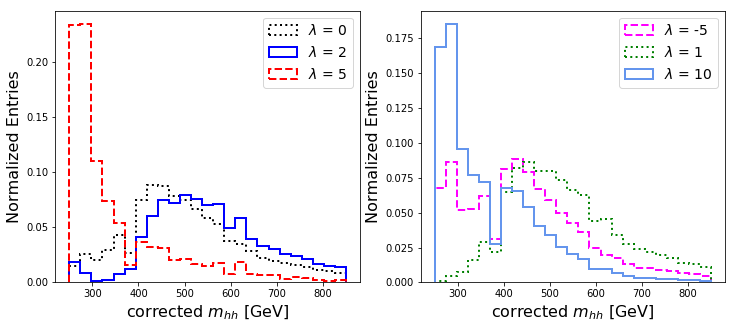

In [79]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(12, 5)

nBins = 25
myRange = (250,850)
lw = 2

for lmbda, c, ls in zip([0,2,5],['k','b','r',],[':','-','--']):
    
    k = 'w_lambda{}'.format(lmbda)
    
    ax1.hist(smnr.loc[sig_SR,'m_hh_cor'],nBins,myRange,
             linestyle=ls,label='$\lambda$ = {}'.format(lmbda),
             color=c,histtype='step',linewidth=lw,
             weights=smnr.loc[sig_SR,k]/np.sum(smnr.loc[sig_SR,k]))
    
    
for lmbda, c, ls in zip([-5,1,10],['magenta','g','cornflowerblue'],['--',':','-']):
    
    k = 'w_lambda{}'.format(lmbda)
    
    ax2.hist(smnr.loc[sig_SR,'m_hh_cor'],nBins,myRange,
             linestyle=ls,label='$\lambda$ = {}'.format(lmbda),
             color=c,histtype='step',linewidth=lw,
             weights=smnr.loc[sig_SR,k]/np.sum(smnr.loc[sig_SR,k]))
    
for ax in [ax1,ax2]:

    ax.set_xlabel('corrected $m_{hh}$ [GeV]',fontsize=16)
    ax.set_ylabel('Normalized Entries',fontsize=16)
    ax.legend(fontsize=14)

plt.savefig('figures/baseline/m_hh_cor_lambdaVar.pdf')

plt.show()
    

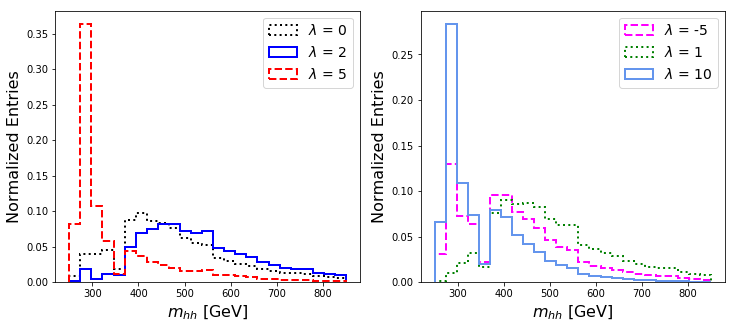

In [80]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(12, 5)

for lmbda, c, ls in zip([0,2,5],['k','b','r',],[':','-','--']):
    
    k = 'w_lambda{}'.format(lmbda)
    
    ax1.hist(smnr.loc[sig_SR,'m_hh'],nBins,myRange,
             linestyle=ls,label='$\lambda$ = {}'.format(lmbda),
             color=c,histtype='step',linewidth=lw,
             weights=smnr.loc[sig_SR,k]/np.sum(smnr.loc[sig_SR,k]))
    
    
for lmbda, c, ls in zip([-5,1,10],['magenta','g','cornflowerblue'],['--',':','-']):
    
    k = 'w_lambda{}'.format(lmbda)
    
    ax2.hist(smnr.loc[sig_SR,'m_hh'],nBins,myRange,
             linestyle=ls,label='$\lambda$ = {}'.format(lmbda),
             color=c,histtype='step',linewidth=lw,
             weights=smnr.loc[sig_SR,k]/np.sum(smnr.loc[sig_SR,k]))
    
for ax in [ax1,ax2]:

    ax.set_xlabel('$m_{hh}$ [GeV]',fontsize=16)
    ax.set_ylabel('Normalized Entries',fontsize=16)
    ax.legend(fontsize=14)

plt.savefig('figures/baseline/m_hh_lambdaVar.pdf')

plt.show()
    

**Step 3:** Get $\mu$ limits for $\kappa_\lambda$ variations that we have.

Good news: Since *all* I've done here is vary the signal sample, we can use the same background estimate for each of these points.


**Baseline analysis**

In [81]:
for test in hypo_tests:
    print(test[1])
    break

[[0.78672885]
 [0.85615339]
 [0.92095331]
 [0.97004695]
 [0.99394614]]


In [82]:
lambdas = np.arange(-20,21)
bands = {i:[] for i in range(-2,3)}

mu_max = 80
mu_tests_lmbda = np.concatenate((np.linspace(.01,.95,25),np.linspace(1,mu_max,4*mu_max)))

qcd_hh_lambda,_ = np.histogram(data16.loc[bkg_SR,'m_hh_cor'], edges,
                               weights=data16.loc[bkg_SR,'w_2b'])

for l in tqdm(lambdas):
    
    # Get the m_hh^{cor} signal histogram so we can start off comparing apples-to-apples   
    sm_hh_lambda,_ = np.histogram(smnr.loc[sig_SR,'m_hh_cor'], edges,
                                  weights=smnr.loc[sig_SR,'w_lambda{}'.format(l)])

    #print("lambda = {}, min sm_hh = {}".format(l,np.min(sm_hh_lambda)))
    '''
    Note from our analysis meeting:
    We were concerned why the ratio plot was spikey, 
    and Max thought is was problematic that I had bins w/ negative
    weights, so I'm going to floor these bins @ 0.
    ''' 
    sm_hh_lambda = np.where(sm_hh_lambda>0,sm_hh_lambda,0)
    
    for i, bi in zip(range(-2,3), getExpectedBand(sm_hh_lambda,qcd_hh_lambda,mu_tests_lmbda)):
        bands[i].append(bi)
    

100%|██████████| 41/41 [03:48<00:00,  5.24s/it]


In [83]:
lambdas[21],bands[0][21]

(1, 20.65621243943602)

In [84]:
mu_HF

20.2959

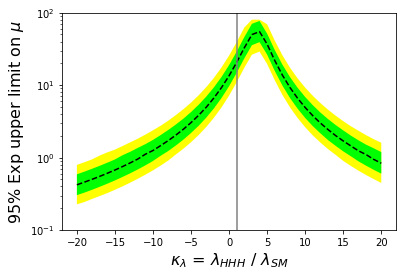

In [85]:
fig, ax = plt.subplots(1,1)
    
ax.semilogy(lambdas,bands[0],'k--')

ax.fill_between(lambdas, bands[-2], bands[2],  facecolor = 'yellow')
ax.fill_between(lambdas, bands[-1], bands[1],  facecolor = 'lime')

ylim = [.1,100]
plt.plot([1]*2,ylim,'grey')
plt.ylim(ylim)

plt.xlabel('$\kappa_\lambda$ = $\lambda_{HHH}$ / $\lambda_{SM}$', fontsize=16)
plt.ylabel('95% Exp upper limit on $\mu$', fontsize=16)

plt.savefig('figures/baseline/kappa_lambda_mu_scan.pdf')

plt.show()

Next: I need to scale this to be an upper limit on the cross-section
1. I can get the smnr cross section by multiplying by $\sigma_{HH}^{SM}$
2. We can get the way $\kappa_\lambda$ scales with the cross-section by taking the *sum* of the weights in the histograms. 

In [86]:
from preprocess import read_tsv

In [87]:
db_entry = read_tsv()

In [88]:
i_mc = 450000

xsec = db_entry.loc[i_mc,"xsec"]

In [89]:
xsec

27.47

^ This cross-section is in fb.

Next, let's look at how the *overall* cross section varies as a function of $\kappa_\lambda$.

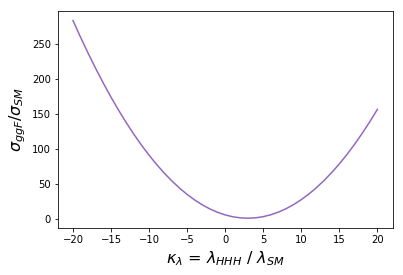

In [90]:
normFactor = np.array([np.sum(smnr.loc[sig_SR,'w_lambda{}'.format(l)]) for l in lambdas])

plt.plot(lambdas,normFactor,'C4')

plt.xlabel('$\kappa_\lambda$ = $\lambda_{HHH}$ / $\lambda_{SM}$', fontsize=16)
plt.ylabel('$\sigma_{ggF} / \sigma_{SM}$', fontsize=16)

plt.show()

In [91]:
# In pb, since this is what the ATLAS plot has
n = 0.001 * xsec * normFactor

In [92]:
stdText = '$\mathbf{ATLAS}$ Internal 2016 data\n'
stdText += r'$\sigma_{ggF}(pp \rightarrow HH)$ = '
stdText += "{:.2f} fb".format(xsec)

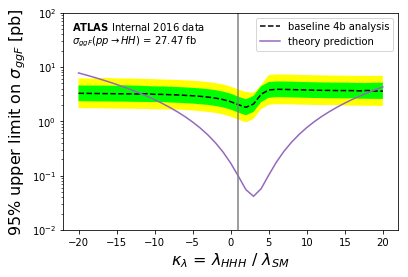

In [93]:
fig, ax = plt.subplots(1,1)
    
ax.semilogy(lambdas, n * np.array(bands[0]),'k--',label='baseline 4b analysis')

ax.fill_between(lambdas, n * np.array(bands[-2]), n * np.array(bands[2]),  facecolor = 'yellow')
ax.fill_between(lambdas, n * np.array(bands[-1]), n * np.array(bands[1]),  facecolor = 'lime')

plt.plot(lambdas,n,'C4',label='theory prediction')

ylim = [.01,100]
plt.plot([1]*2,ylim,'grey')
plt.ylim(ylim)

plt.xlabel('$\kappa_\lambda$ = $\lambda_{HHH}$ / $\lambda_{SM}$', fontsize=16)
plt.ylabel('95% upper limit on $\sigma_{ggF}$ [pb]', fontsize=16)

plt.legend()

ax.text(0.025,.95,stdText,ha='left',va='top',transform=ax.transAxes)

plt.savefig('figures/baseline/kappa_lambda_scan.pdf')

plt.show()

**Question from Danny:** Why is the 4b analysis flat as a function of $\kappa_\lambda$?

But I have the plot... This is *awesome*!!!! Next, I want to compare how some of my alternatives to the baseline analysis perform in terms of this $\kappa_\lambda$ variation.

- Baseline: Not rescaling the HCs
- Valid pairings categories
- Baseline: 2d fit with $\Delta \eta_{hh}$
- min $\Delta R_{jj}^{HC1}$
- min $\Delta R_{jj}^{HC1}$ with the $\Delta \eta_{hh}$ categories


The only thing though, is that since these lambda variations were derived (I think) just using the final histograms, maybe there's no way any of my conclusions hold when I'm looking at a new pairing algorithm?

**Baseline: W/o rescaling the HCs**

In [94]:
bands_unsc = {i:[] for i in range(-2,3)}

for l in tqdm(lambdas):
    
    # Get a new signal histogram
    sm_hh_l,_ = np.histogram(smnr.loc[sig_SR,'m_hh'], edges,
                                  weights=smnr.loc[sig_SR,'w_lambda{}'.format(l)])
    
    sm_hh_l = np.where(sm_hh_l>0,sm_hh_l,0)
    
    for i, bi in zip(range(-2,3), getExpectedBand(sm_hh_l, qcd_hh, mu_tests_lmbda)):
        bands_unsc[i].append(bi)
    

100%|██████████| 41/41 [03:46<00:00,  5.26s/it]


In [96]:
#assert bands_unsc[0][21]==mu_unsc

**Valid pairings categories**


Note: It *might* be cool to make the $m_{hh}$ for the various $\kappa_\lambda$ values plot for all of my different valid pairings categories :)


In [97]:
(myRange[1]-myRange[0])/15

40.0

In [98]:
myRange

(250, 850)

Note: Since I'm flooring negative values for the $\kappa_\lambda$ plot, it's worthwhile to floor them in this plot as well.

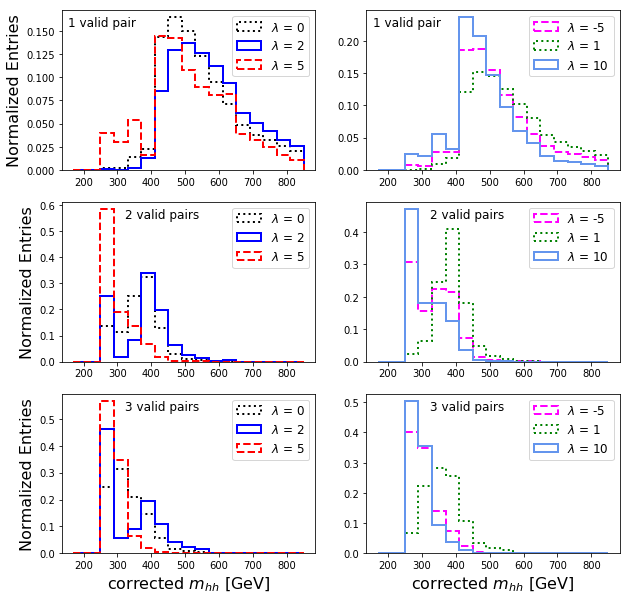

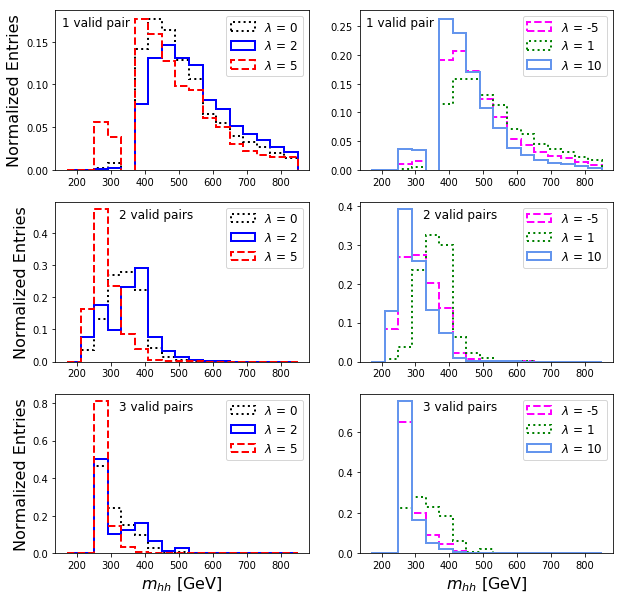

In [99]:
nBins = 17
myRange = (170,850)

for col,xlabel in zip(['m_hh_cor','m_hh'],['corrected $m_{hh}$ [GeV]','$m_{hh}$ [GeV]']):

    fig, axes = plt.subplots(3,2)
    fig.set_size_inches(10, 10)

    for nv, (ax1, ax2) in zip([1,2,3],axes):

        mask = sig_SR & (smnr.nValidPairs == nv)

        for lmbda, c, ls in zip([0,2,5],['k','b','r',],[':','-','--']):

            k = 'w_lambda{}'.format(lmbda)
            
            ax1.hist(smnr.loc[mask,col],nBins,myRange,
                     linestyle=ls,label='$\lambda$ = {}'.format(lmbda),
                     color=c,histtype='step',linewidth=lw,
                     weights=smnr.loc[mask,k]/np.sum(smnr.loc[mask,k]))


        for lmbda, c, ls in zip([-5,1,10],['magenta','g','cornflowerblue'],['--',':','-']):

            k = 'w_lambda{}'.format(lmbda)

            ax2.hist(smnr.loc[mask,col],nBins,myRange,
                     linestyle=ls,label='$\lambda$ = {}'.format(lmbda),
                     color=c,histtype='step',linewidth=lw,
                     weights=smnr.loc[mask,k]/np.sum(smnr.loc[mask,k]))

        ax1.set_ylabel('Normalized Entries',fontsize=16)

        for ax in [ax1,ax2]:
            ax.legend(fontsize=12)

            ax.text(0.025 if nv==1 else .25, 0.96,
                    "{} valid pair{}".format(nv,"s" if nv != 1 else ""),
                    ha='left',va='top',transform=ax.transAxes,fontsize=12)

            _,ymax = ax.get_ylim()
            ax.set_ylim(0,ymax)
            
    for ax in [ax1,ax2]:
        ax.set_xlabel(xlabel,fontsize=16)

    plt.savefig('figures/baseline/{}_lambdaVar_nv.pdf'.format(col))

    plt.show()


In [100]:
bands_nv = {i:[] for i in range(-2,3)}

for l in tqdm(lambdas):
        
    sm_hh_nv,_,_  = np.histogram2d(smnr.loc[sig_SR,'m_hh'], smnr.loc[sig_SR,'nValidPairs'], 
                                   [edges, nv_edges], weights=smnr.loc[sig_SR,'w_lambda{}'.format(l)])
       
    # Recall: By default this hist2dToList will floor negative values
    for i, bi in zip(range(-2,3), getExpectedBand(hist2dToList(sm_hh_nv), hist2dToList(qcd_hh_nv), mu_tests_lmbda)):
        bands_nv[i].append(bi)
    

100%|██████████| 41/41 [03:52<00:00,  5.60s/it]


Ok, so let's take a look at what this results look like!

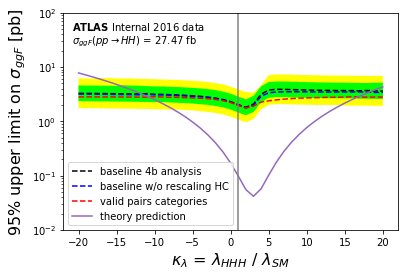

In [102]:
fig, ax = plt.subplots(1,1)
    
ax.semilogy(lambdas, n * np.array(bands[0]),'k--',label='baseline 4b analysis')

ax.fill_between(lambdas, n * np.array(bands[-2]), n * np.array(bands[2]),  facecolor = 'yellow')
ax.fill_between(lambdas, n * np.array(bands[-1]), n * np.array(bands[1]),  facecolor = 'lime')

# The extra bands that I wanted to add
ax.semilogy(lambdas, n * np.array(bands_unsc[0]),'b--',label='baseline w/o rescaling HC')
ax.semilogy(lambdas, n * np.array(bands_nv[0]),'r--',label='valid pairs categories')

plt.plot(lambdas,n,'C4',label='theory prediction')

ylim = [.01,100]
plt.plot([1]*2,ylim,'grey')
plt.ylim(ylim)

plt.xlabel('$\kappa_\lambda$ = $\lambda_{HHH}$ / $\lambda_{SM}$', fontsize=16)
plt.ylabel('95% upper limit on $\sigma_{ggF}$ [pb]', fontsize=16)

plt.legend(loc='lower left')

ax.text(0.025,.95,stdText,ha='left',va='top',transform=ax.transAxes)

plt.savefig('figures/baseline/kappa_lambda_scan_numberOfValidPairs.pdf')

plt.show()

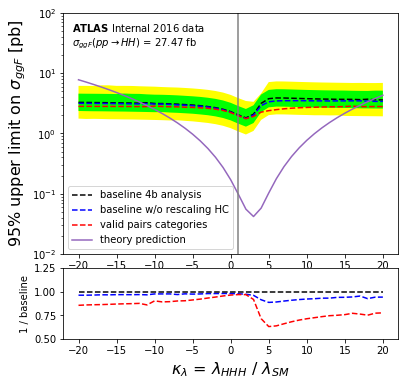

In [104]:
fig = plt.figure(figsize=(6, 6))

gs = gridspec.GridSpec(4,1)
ax = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax)

ax.semilogy(lambdas, n * np.array(bands[0]),'k--',label='baseline 4b analysis')

ax.fill_between(lambdas, n * np.array(bands[-2]), n * np.array(bands[2]),  facecolor = 'yellow')
ax.fill_between(lambdas, n * np.array(bands[-1]), n * np.array(bands[1]),  facecolor = 'lime')

# The extra bands that I wanted to add
ax.semilogy(lambdas, n * np.array(bands_unsc[0]),'b--',label='baseline w/o rescaling HC')
ax.semilogy(lambdas, n * np.array(bands_nv[0]),'r--',label='valid pairs categories')

ax.plot(lambdas,n,'C4',label='theory prediction')

ylim = [.01,100]
ax.plot([1]*2,ylim,'grey')
ax.set_ylim(ylim)

ax.set_ylabel('95% upper limit on $\sigma_{ggF}$ [pb]', fontsize=16)
ax.legend(loc='lower left')

ax2.plot(lambdas,np.array(bands_unsc[0])/np.array(bands[0]),'b--')
ax2.plot(lambdas,np.array(bands_nv[0])/np.array(bands[0]),'r--')

ax2.plot(lambdas,np.ones_like(lambdas),'k--')

ax2.set_xlabel('$\kappa_\lambda$ = $\lambda_{HHH}$ / $\lambda_{SM}$', fontsize=16)
ax2.set_ylabel('1 / baseline')
ax2.set_ylim(0.5,1.25)

ax.text(0.025,.95,stdText,ha='left',va='top',transform=ax.transAxes)

plt.savefig('figures/baseline/kappa_lambda_scan_numberOfValidPairs_ratio.pdf')

plt.show()


**Next:** Compare how these limits depended on the individual categories

In [105]:
bands_nv_ind = {'{} valid pair'.format(nv) : {i:[] for i in range(-2,3)} for nv in [1,2,3]}

for nv in [1,2,3]:
    
    b, _ = np.histogram(data16.loc[bkg_SR & (data16.nValidPairs == nv),'m_hh'], 
                        edges, weights=data16.loc[bkg_SR & (data16.nValidPairs == nv),'w_2b'])
        

    for l in tqdm(lambdas):

        s,_  = np.histogram(smnr.loc[sig_SR & (smnr.nValidPairs == nv),'m_hh'], 
                            edges, weights=smnr.loc[sig_SR & (smnr.nValidPairs == nv),'w_lambda{}'.format(l)])

        for i, bi in zip(range(-2,3), getExpectedBand(s, b, mu_tests_lmbda)):
            bands_nv_ind['{} valid pair'.format(nv)][i].append(bi)


  0%|          | 0/41 [00:00<?, ?it/s]/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
 51%|█████     | 21/41 [01:51<02:05,  6.27s/it]/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/utils.py:168: RuntimeWarning: invalid value encountered in true_divide
  nullval = (qmu + qmu_A) / (2 * sqrtqmuA_v)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/utils.py:169: RuntimeWarning: invalid value encountered in true_divide
  altval = (qmu - qmu_A) / (2 * sqrtqmuA_v)
100%|██████████| 41/41 [03:23<00:00,  4.73s/it]


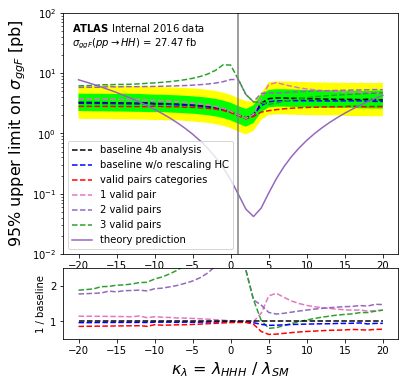

In [107]:
fig = plt.figure(figsize=(6, 6))

gs = gridspec.GridSpec(4,1)
ax = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax)

ax.semilogy(lambdas, n * np.array(bands[0]),'k--',label='baseline 4b analysis')

ax.fill_between(lambdas, n * np.array(bands[-2]), n * np.array(bands[2]),  facecolor = 'yellow')
ax.fill_between(lambdas, n * np.array(bands[-1]), n * np.array(bands[1]),  facecolor = 'lime')

# The extra bands that I wanted to add
ax.semilogy(lambdas, n * np.array(bands_unsc[0]),'b--',label='baseline w/o rescaling HC')
ax.semilogy(lambdas, n * np.array(bands_nv[0]),'r--',label='valid pairs categories')

for nv,c in zip([1,2,3],['C6','C4','C2']):
    key = "{} valid pair".format(nv)
    ax.semilogy(lambdas, n * np.array(bands_nv_ind[key][0]),color=c,linestyle='--',label=key+("s" if nv != 1 else ""))
    ax2.plot(lambdas,np.array(bands_nv_ind[key][0])/np.array(bands[0]),color=c,linestyle='--')

#ax.semilogy(lambdas, n * np.array(bands_eta[0]),'g--',label='with $|\Delta \eta_{hh}|$')

ax.plot(lambdas,n,'C4',label='theory prediction')

ylim = [.01,100]
ax.plot([1]*2,ylim,'grey')
ax.set_ylim(ylim)

ax.set_ylabel('95% upper limit on $\sigma_{ggF}$ [pb]', fontsize=16)
ax.legend(loc='lower left')

ax2.plot(lambdas,np.array(bands_unsc[0])/np.array(bands[0]),'b--')
ax2.plot(lambdas,np.array(bands_nv[0])/np.array(bands[0]),'r--')
#ax2.plot(lambdas,np.array(bands_eta[0])/np.array(bands[0]),'g--')

ax2.plot(lambdas,np.ones_like(lambdas),'k--')

ax2.set_xlabel('$\kappa_\lambda$ = $\lambda_{HHH}$ / $\lambda_{SM}$', fontsize=16)
ax2.set_ylabel('1 / baseline')
ax2.set_ylim(0.5,2.5)

ax.text(0.025,.95,stdText,ha='left',va='top',transform=ax.transAxes)

plt.savefig('figures/baseline/kappa_lambda_scan_separateCategories.pdf')

plt.show()


**Baseline: 2d fit with $\Delta \eta_{hh}$**

In [ ]:
bands_eta = {i:[] for i in range(-2,3)}

for l in tqdm(lambdas):
      
    sm_hh_eta,_,_  = np.histogram2d(smnr.loc[sig_SR,'m_hh'], smnr.loc[sig_SR,'deta_hh'], 
                                   [edges, eta_edges], weights=smnr.loc[sig_SR,'w_lambda{}'.format(l)])
        
    for i, bi in zip(range(-2,3), getExpectedBand(hist2dToList(sm_hh_eta), hist2dToList(qcd_hh_eta), mu_tests_lmbda)):
        bands_eta[i].append(bi)
    

In [ ]:
nBins = 17
myRange = (170,850)

for col,xlabel in zip(['m_hh_cor','m_hh'],['corrected $m_{hh}$ [GeV]','$m_{hh}$ [GeV]']):

    fig, axes = plt.subplots(3,2)
    fig.set_size_inches(10, 10)

    for min_eta,max_eta, (ax1, ax2) in zip(eta_edges[:-1],eta_edges[1:],axes):

        mask = sig_SR & (smnr.deta_hh > min_eta) & (smnr.deta_hh < max_eta)

        for lmbda, c, ls in zip([0,2,5],['k','b','r',],[':','-','--']):

            k = 'w_lambda{}'.format(lmbda)
            
            ax1.hist(smnr.loc[mask,col],nBins,myRange,
                     linestyle=ls,label='$\lambda$ = {}'.format(lmbda),
                     color=c,histtype='step',linewidth=lw,
                     weights=smnr.loc[mask,k]/np.sum(smnr.loc[mask,k]))


        for lmbda, c, ls in zip([-5,1,10],['magenta','g','cornflowerblue'],['--',':','-']):

            k = 'w_lambda{}'.format(lmbda)

            ax2.hist(smnr.loc[mask,col],nBins,myRange,
                     linestyle=ls,label='$\lambda$ = {}'.format(lmbda),
                     color=c,histtype='step',linewidth=lw,
                     weights=smnr.loc[mask,k]/np.sum(smnr.loc[mask,k]))

        ax1.set_ylabel('Normalized Entries',fontsize=16)

        for ax in [ax1,ax2]:
            ax.legend(fontsize=12)

            ax.text(0.025 if nv==1 else .25, 0.96,
                    str(min_eta) + " < $|\eta_{hh}|$ < " + str(max_eta),
                    ha='left',va='top',transform=ax.transAxes,fontsize=12)

            _,ymax = ax.get_ylim()
            ax.set_ylim(0,ymax)
            
    for ax in [ax1,ax2]:
        ax.set_xlabel(xlabel,fontsize=16)

    plt.savefig('figures/baseline/{}_lambdaVar_detahh.pdf'.format(col))

    plt.show()



In [ ]:
fig, ax = plt.subplots(1,1)
    
ax.semilogy(lambdas, n * np.array(bands[0]),'k--',label='baseline 4b analysis')

ax.fill_between(lambdas, n * np.array(bands[-2]), n * np.array(bands[2]),  facecolor = 'yellow')
ax.fill_between(lambdas, n * np.array(bands[-1]), n * np.array(bands[1]),  facecolor = 'lime')

# The extra bands that I wanted to add
ax.semilogy(lambdas, n * np.array(bands_unc[0]),'b--',label='baseline w/o rescaling HC')
ax.semilogy(lambdas, n * np.array(bands_nv[0]),'r--',label='valid pairs categories')
ax.semilogy(lambdas, n * np.array(bands_eta[0]),'g--',label='with $|\Delta \eta_{hh}|$')

plt.plot(lambdas,n,'C4',label='theory prediction')

ylim = [.01,100]
plt.plot([1]*2,ylim,'grey')
plt.ylim(ylim)

plt.xlabel('$\kappa_\lambda$ = $\lambda_{HHH}$ / $\lambda_{SM}$', fontsize=16)
plt.ylabel('95% upper limit on $\sigma_{ggF}$ [pb]', fontsize=16)

plt.legend(loc='lower left')

ax.text(0.025,.95,stdText,ha='left',va='top',transform=ax.transAxes)

plt.savefig('figures/baseline/kappa_lambda_scan_deta.pdf')

plt.show()

In [ ]:
fig = plt.figure(figsize=(6, 6))

gs = gridspec.GridSpec(4,1)
ax = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax)

ax.semilogy(lambdas, n * np.array(bands[0]),'k--',label='baseline 4b analysis')

ax.fill_between(lambdas, n * np.array(bands[-2]), n * np.array(bands[2]),  facecolor = 'yellow')
ax.fill_between(lambdas, n * np.array(bands[-1]), n * np.array(bands[1]),  facecolor = 'lime')

# The extra bands that I wanted to add
ax.semilogy(lambdas, n * np.array(bands_unc[0]),'b--',label='baseline w/o rescaling HC')
ax.semilogy(lambdas, n * np.array(bands_nv[0]),'r--',label='valid pairs categories')
ax.semilogy(lambdas, n * np.array(bands_eta[0]),'g--',label='with $|\Delta \eta_{hh}|$')

ax.plot(lambdas,n,'C4',label='theory prediction')

ylim = [.01,100]
ax.plot([1]*2,ylim,'grey')
ax.set_ylim(ylim)

ax.set_ylabel('95% upper limit on $\sigma_{ggF}$ [pb]', fontsize=16)
ax.legend(loc='lower left')

ax2.plot(lambdas,np.array(bands_unc[0])/np.array(bands[0]),'b--')
ax2.plot(lambdas,np.array(bands_nv[0])/np.array(bands[0]),'r--')
ax2.plot(lambdas,np.array(bands_eta[0])/np.array(bands[0]),'g--')

ax2.plot(lambdas,np.ones_like(lambdas),'k--')

ax2.set_xlabel('$\kappa_\lambda$ = $\lambda_{HHH}$ / $\lambda_{SM}$', fontsize=16)
ax2.set_ylabel('1 / baseline')
ax2.set_ylim(0.5,1.25)

ax.text(0.025,.95,stdText,ha='left',va='top',transform=ax.transAxes)

plt.savefig('figures/baseline/kappa_lambda_scan_deta_ratio.pdf')

plt.show()



**min $\Delta R_{jj}^{HC 1}$**

- Load in the BDT
- Look at the $m_{hh}$ plot with the $s / \sqrt{b}$ in the ratio below as well
- Overlay the $m_{hh}$ plots for the two pairing algs, just to demonstrate that the background in the SR that we were cutting out was predominantly due to the low $m_{4j}$

In [ ]:
minR1_fileName = "../../hh4b-resolved-reconstruction/{}_topo16_min_Rjj_h1_vec.root"

minR1_smnr   = nanoToDf(minR1_fileName.format("smnr"),ttree='fullmassplane')
minR1_data16 = nanoToDf(minR1_fileName.format("data16"),ttree='fullmassplane')

In [ ]:
minR1_BDT_fname = "myBDTs/BDT_d24_16_rel21_vec_min_dRjj_h1_vec.p"

minR1_reweighter = pickle.load(open( minR1_BDT_fname, "rb" ))


In [ ]:
minR1_smnr_SB   = nanoToDf(minR1_fileName.format("smnr"),ttree='sideband')
minR1_data16_SB = nanoToDf(minR1_fileName.format("data16"),ttree='sideband')

minR1_N4bTo2b = np.sum((minR1_data16_SB.ntag>=4) & (minR1_data16_SB.kinematic_region==2)) \
                / np.sum((minR1_data16_SB.ntag==2) & (minR1_data16_SB.kinematic_region==2))


In [ ]:
minR1_data16['w_2b'] = minR1_N4bTo2b * minR1_reweighter.predict_weights(minR1_data16[sort_rw_cols])

In [ ]:
minR1_dataText = "$\mathbf{ATLAS}$ Internal 2016 data\n"
minR1_dataText += " min $\Delta R_{jj}^{HC1}$"

In [ ]:
minR1_bkg_SR = (minR1_data16.ntag==2)&(minR1_data16.kinematic_region==0)
minR1_sig_SR = (minR1_smnr.ntag>=4)&(minR1_smnr.kinematic_region==0)

In [ ]:
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(4,1)
ax1 = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax1)

b,_,_ = ax1.hist(minR1_data16.loc[minR1_bkg_SR,'m_hh'],
                 edges,color='C9',histtype='step',log=True,
                 label='reweighted 2b',
                 weights=minR1_data16.loc[minR1_bkg_SR,'w_2b'])

s,_,_ = ax1.hist(minR1_smnr.loc[minR1_sig_SR,'m_hh'],
                 edges,color='C1',histtype='step',log=True,
                 label='SM',
                 weights=minR1_smnr.loc[minR1_sig_SR,'mc_sf'])

ax2.plot(0.5*(edges[:-1]+edges[1:]),s/np.sqrt(b),marker='.',color='C1',linewidth=0)
ax2.set_xlabel('$m_{hh}$',fontsize=16)
ax2.set_ylim(0,.035)

_,ymax = ax1.get_ylim()
ax1.set_ylim(0,ymax)

ax1.set_ylabel('Entries',fontsize=16)
ax1.text(0,1,minR1_dataText,ha='left',va='bottom',transform=ax1.transAxes)

sigText = '$\sqrt{\sum_i{s_i^2 / b_i}}$ = '
sigText += '{:.3f}'.format(np.sqrt(np.sum(s[b!=0]**2 / b[b!=0])))

ax2.text(.975,.9,sigText,ha='right',va='top',transform=ax2.transAxes)
ax2.set_ylabel('$s / \sqrt{b}$',fontsize=16)

ax1.legend(fontsize=12,loc="lower left")

ax1.set_title('signal region', loc='right',fontsize=14)

plt.savefig('figures/min_dRjj1/m_hh_SR_log_ratio.pdf',bbox_inches='tight')

plt.show()

In [ ]:
np.min(s)

Let's just sanity check some numbers that I dervied before.

In [ ]:
s.sum()

In [ ]:
b.sum()

Just to drive the point home... let's overlay them!

In [ ]:
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(4,1)
ax1 = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax1)

b0,_,_ = ax1.hist(data16.loc[bkg_SR,'m_hh'],
                 edges,color='C9',histtype='step',log=True,
                 label='baseline: rw 2b',
                 weights=data16.loc[bkg_SR,'w_2b'])

s0,_,_ = ax1.hist(smnr.loc[sig_SR,'m_hh'],
                 edges,color='C4',histtype='step',log=True,
                 label='baseline: SM',
                 weights=smnr.loc[sig_SR,'mc_sf'])

b,_,_ = ax1.hist(minR1_data16.loc[minR1_bkg_SR,'m_hh'],
                 edges,color='C9',histtype='step',log=True,linestyle='--',
                 label='min $\Delta R_{jj}^{HC1}$: rw 2b',
                 weights=minR1_data16.loc[minR1_bkg_SR,'w_2b'])

s,_,_ = ax1.hist(minR1_smnr.loc[minR1_sig_SR,'m_hh'],
                 edges,color='C1',histtype='step',log=True,
                 label='min $\Delta R_{jj}^{HC1}$: SM',
                 weights=minR1_smnr.loc[minR1_sig_SR,'mc_sf'])

x = 0.5*(edges[:-1]+edges[1:])
ax2.plot(x, s0/np.sqrt(b0),marker='.',color='C4',linewidth=0)
ax2.plot(x, s /np.sqrt(b), marker='.',color='C1',linewidth=0)
ax2.set_xlabel('$m_{hh}$',fontsize=16)
ax2.set_ylim(0,.035)

_,ymax = ax1.get_ylim()
ax1.set_ylim(0,ymax)

ax1.set_ylabel('Entries',fontsize=16)
ax1.text(0,1,"$\mathbf{ATLAS}$ Internal 2016 data\nComparing HC pairing algs",
         ha='left',va='bottom',transform=ax1.transAxes)

sigText = '$\sqrt{\sum_i{s_i^2 / b_i}}$ = '

ax2.text(.975,.95,
         sigText+'{:.3f}'.format(np.sqrt(np.sum(s0[b0!=0]**2 / b0[b0!=0]))),
         ha='right',va='top',transform=ax2.transAxes,color='C4')
ax2.text(.975,.475,
         sigText+'{:.3f}'.format(np.sqrt(np.sum(s[b!=0]**2 / b[b!=0]))),
         ha='right',va='top',transform=ax2.transAxes,color='C1')
ax2.set_ylabel('$s / \sqrt{b}$',fontsize=16)

ax1.legend(fontsize=12,bbox_to_anchor=(1,1.03))

ax1.set_title('signal region', loc='right',fontsize=14)

plt.savefig('figures/min_dRjj1/m_hh_SR_log_ratio_cf_baseline.pdf',bbox_inches='tight')

plt.show()

Ok, so we can see from here that the new pairing is a slight improvement for the significance, although it gave a *huge* drop in the background.

I think the most interesting part of this plot is that you can see that we've slightly lost the signal at low $m_{hh}$.

**Get the $\kappa_\lambda$ plot**

I really liked these $\kappa_\lambda$ plots... let's recreate them!

(Should I overlay the pairing algs with solid and dashed lines?)

Also, I'm just going to look at the *uncorrected* $m_{hh}$, because this was the one that I'm using to set the limit, and these were the plots that I ended up showing in the 4b analysis meeting.


In [ ]:
for ttree in f.keys():
    
    tree = uproot.open(lambdaFile)[ttree]
    
    idx = np.digitize(minR1_smnr['m_hh_cor'],tree.edges) 
    
    l = ttree.decode()[13:][:-2]
    minR1_smnr['w_lambda{}'.format(int(l))] = tree.allvalues[idx] * minR1_smnr['mc_sf']

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(12, 5)

nBins = 25
myRange = (250,850)
lw = 2

for lmbda, c, ls in zip([0,2,5],['k','b','r',],[':','-','--']):
    
    k = 'w_lambda{}'.format(lmbda)
    
    ax1.hist(smnr.loc[sig_SR,'m_hh_cor'],nBins,myRange,
             linestyle='-',label='$\lambda$ = {}'.format(lmbda),
             color=c,histtype='step',linewidth=lw,
             weights=smnr.loc[sig_SR,k]/np.sum(smnr.loc[sig_SR,k]))
    
    ax1.hist(minR1_smnr.loc[minR1_sig_SR,'m_hh_cor'],nBins,myRange,
             linestyle='--',label='$\lambda$ = {}'.format(lmbda),
             color=c,histtype='step',linewidth=lw,
             weights=minR1_smnr.loc[minR1_sig_SR,k]/np.sum(minR1_smnr.loc[minR1_sig_SR,k]))
    
    
    
for lmbda, c, ls in zip([-5,1,10],['magenta','g','cornflowerblue'],['--',':','-']):
    
    k = 'w_lambda{}'.format(lmbda)
    
    ax2.hist(smnr.loc[sig_SR,'m_hh_cor'],nBins,myRange,
             linestyle='-',label='$\lambda$ = {}'.format(lmbda),
             color=c,histtype='step',linewidth=lw,
             weights=smnr.loc[sig_SR,k]/np.sum(smnr.loc[sig_SR,k]))
    
    
    ax2.hist(minR1_smnr.loc[minR1_sig_SR,'m_hh_cor'],nBins,myRange,
             linestyle='--',label='$\lambda$ = {}'.format(lmbda),
             color=c,histtype='step',linewidth=lw,
             weights=minR1_smnr.loc[minR1_sig_SR,k]/np.sum(minR1_smnr.loc[minR1_sig_SR,k]))
    
for ax in [ax1,ax2]:

    ax.set_xlabel('corrected $m_{hh}$ [GeV]',fontsize=16)
    ax.set_ylabel('Normalized Entries',fontsize=16)
    ax.legend(fontsize=14)

plt.savefig('figures/min_dRjj1/m_hh_cor_lambdaVar_cf_baseline.pdf')

plt.show()

Ok, so this is consistent with what Beojean saw before and what I was seeing in the $m_{hh}$ spectrum. The min $\Delta R_{jj}^{HC1}$ really isn't great @ low $m_{4j}$.

**Rafael's suggestions:**
- Normalize the dashed lines to the full lines to get an idea of the efficiency
- Make this plot log scale
- Add the 2d reweighted background shape on the same plot as well.

In [ ]:
lambds = [[0,-5],[2,1],[5,10]]
colors = [['k','magenta'],['b','g'],['r','cornflowerblue']]

for col,xlabel in zip(['m_hh_cor','m_hh'],['corrected $m_{hh}$ [GeV]','$m_{hh}$ [GeV]']):

    fig, axes = plt.subplots(3,2)
    fig.set_size_inches(10, 10)

    for rows, row_ls, row_cs in zip(axes,lambds,colors):

        for ax, lmbda, c in zip(rows, row_ls,row_cs):

            k = 'w_lambda{}'.format(lmbda)

            norm = np.sum(smnr.loc[sig_SR,k])

            ax.hist(smnr.loc[sig_SR,col],nBins,myRange,
                 linestyle='-',label='baseline',
                 color=c,histtype='step',linewidth=lw,
                 weights=smnr.loc[sig_SR,k]/norm)

            ax.hist(minR1_smnr.loc[minR1_sig_SR,col],nBins,myRange,
                 linestyle='--',label='min $\Delta R_{jj}^{HC1}$',
                 color=c,histtype='step',linewidth=lw,
                 weights=minR1_smnr.loc[minR1_sig_SR,k]/norm)

            ax.legend(fontsize=12)
            ax.text(0.3 if lmbda > 4 else 0.05, 
                    0.95,"$\lambda$ = {}".format(lmbda),
                    ha='left',va='top',transform=ax.transAxes,fontsize=14)

    for ax in axes[-1]: 
        ax.set_xlabel(xlabel,fontsize=16)

    for ax in axes[:,0]: 
        ax.set_ylabel('Entries normalized to baseline')


    plt.savefig('figures/min_dRjj1/{}_3x2_lambdas_cf_baseline.pdf'.format(col))

    plt.show()

In [ ]:
bands_minR1 = {i:[] for i in range(-2,3)}

for l in tqdm(lambdas):
    
    # Get a new signal histogram
    sm_hh_minR1,_ = np.histogram(minR1_smnr.loc[minR1_sig_SR,'m_hh'], edges,
                                 weights=minR1_smnr.loc[minR1_sig_SR,'w_lambda{}'.format(l)])
    
    for i, bi in zip(range(-2,3), getExpectedBand(sm_hh_minR1, b, mu_tests_lmbda)):
        bands_minR1[i].append(bi)

In [ ]:
fig, ax = plt.subplots(1,1)
    
ax.semilogy(lambdas, n * np.array(bands[0]),'k--',label='baseline 4b analysis')

ax.fill_between(lambdas, n * np.array(bands[-2]), n * np.array(bands[2]),  facecolor = 'yellow')
ax.fill_between(lambdas, n * np.array(bands[-1]), n * np.array(bands[1]),  facecolor = 'lime')

# The extra bands that I wanted to add
ax.semilogy(lambdas, n * np.array(bands_unc[0]),'b--',label='baseline w/o rescaling HC')
ax.semilogy(lambdas, n * np.array(bands_nv[0]),'r--',label='valid pairs categories')
#ax.semilogy(lambdas, n * np.array(bands_eta[0]),'g--',label='with $|\Delta \eta_{hh}|$')
ax.semilogy(lambdas, n * np.array(bands_minR1[0]),'g--',label='min $\Delta R_{jj}^{HC1}$')

plt.plot(lambdas,n,'C4',label='theory prediction')

ylim = [.01,100]
plt.plot([1]*2,ylim,'grey')
plt.ylim(ylim)

plt.xlabel('$\kappa_\lambda$ = $\lambda_{HHH}$ / $\lambda_{SM}$', fontsize=16)
plt.ylabel('95% upper limit on $\sigma_{ggF}$ [pb]', fontsize=16)

plt.legend(loc='lower left')

ax.text(0.025,.95,stdText,ha='left',va='top',transform=ax.transAxes)

plt.savefig('figures/min_dRjj1/kappa_lambda_scan_cf_baseline.pdf')

plt.show()

In [ ]:
fig = plt.figure(figsize=(6, 6))

gs = gridspec.GridSpec(4,1)
ax = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax)

ax.semilogy(lambdas, n * np.array(bands[0]),'k--',label='baseline 4b analysis')

ax.fill_between(lambdas, n * np.array(bands[-2]), n * np.array(bands[2]),  facecolor = 'yellow')
ax.fill_between(lambdas, n * np.array(bands[-1]), n * np.array(bands[1]),  facecolor = 'lime')

# The extra bands that I wanted to add
ax.semilogy(lambdas, n * np.array(bands_unc[0]),'b--',label='baseline w/o rescaling HC')
ax.semilogy(lambdas, n * np.array(bands_nv[0]),'r--',label='valid pairs categories')
ax.semilogy(lambdas, n * np.array(bands_minR1[0]),'g--',label='min $\Delta R_{jj}^{HC1}$')

ax.plot(lambdas,n,'C4',label='theory prediction')

ylim = [.01,100]
ax.plot([1]*2,ylim,'grey')
ax.set_ylim(ylim)

ax.set_ylabel('95% upper limit on $\sigma_{ggF}$ [pb]', fontsize=16)
ax.legend(loc='lower left')

ax2.plot(lambdas,np.array(bands_unc[0])/np.array(bands[0]),'b--')
ax2.plot(lambdas,np.array(bands_nv[0])/np.array(bands[0]),'r--')
ax2.plot(lambdas,np.array(bands_minR1[0])/np.array(bands[0]),'g--')

ax2.plot(lambdas,np.ones_like(lambdas),'k--')

ax2.set_xlabel('$\kappa_\lambda$ = $\lambda_{HHH}$ / $\lambda_{SM}$', fontsize=16)
ax2.set_ylabel('1 / baseline')
ax2.set_ylim(0.5,1.6)

ax.text(0.025,.95,stdText,ha='left',va='top',transform=ax.transAxes)

plt.savefig('figures/min_dRjj1/kappa_lambda_scan_cf_baseline_ratio.pdf')

plt.show()

Ok, so this new pairing really hurts us in terms of the $\kappa_\lambda$ limit.

**Get the SM NR limit.**

I think the most important part here is that I have the curves on this plot that I am going to put on the other plot!

It might also be nice to have the analysis improvement (or lack thereof) included on the plot as well.


In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

labels = [
    'baseline 4b analysis',
    'baseline w/o rescaling HC',
    'valid pairs categories',
    '$\Delta \eta_{hh}$ bins',
    'min $\Delta R_{jj}^{HC1}$'
]

eps = .1


exp_bands = [[b[i][21] for i in range(-2,3)] for b in [bands,bands_unc,bands_nv,bands_eta,bands_minR1]]

mu_baseline = bands[0][21]

for i,(ymin, cls_exp) in enumerate(zip(np.arange(len(labels))[::-1],
                                       exp_bands)):
    
    gain = (mu_baseline-cls_exp[2])/mu_baseline*100
    print(gain)
    
    plt.fill_between([cls_exp[0],cls_exp[-1]], [ymin+eps]*2,[ymin+1-eps]*2, 
                     facecolor = 'yellow', 
                     label='Expected $\pm 1\sigma$' if i==0 else None)
    plt.fill_between([cls_exp[1],cls_exp[-2]], [ymin+eps]*2,[ymin+1-eps]*2, 
                     facecolor = 'lime', 
                     label='Expected $\pm 2\sigma$' if i==0 else None)
    
    plt.plot([cls_exp[2]]*2,[ymin+eps,ymin+1-eps],'k--',
             label='Expected' if i==0 else None)
    
    
    if i==0:
        plt.text(40,ymin+0.5,'% Improvement')
    else:
        plt.text(40,ymin+0.5,"{:.1f}% improvement".format(gain))
    
    
ax.set_yticks(np.arange(5)+0.5)
ax.set_yticklabels(labels[::-1])   
 
'''
Put some text on the top of the figure corresponding 
to the signal that we're looking at.
'''
plt.ylim(0,7)
plt.text(0.05,0.95,stdText,ha='left',va='top',transform=ax.transAxes)
plt.legend(loc='upper right')
    
plt.xlabel(r'95% CL upper limit of $\sigma_{ggF}(pp \rightarrow HH)$ normalized to $\sigma_{ggF}^{SM}$')

plt.savefig('figures/min_dRjj1/exp_mu_cf_validPairs.pdf',bbox_inches='tight')

plt.show()

**min $\Delta R_{jj}^{HC 1}$ with the $\Delta \eta_{hh}$ categories**

- Remake the $\Delta \eta_{hh}$ plots for this pairing alg!